<h1 align="center"> Road Sign Image Classifier with Keras

<h1 align="center"> Program Start

  (1) Create Train, Test, and Validation Data
<br>

  (2) Explore Response Variable
  <br>
  
  (3) Distribution of Responses Among Different Sets
  <br>
  
  (4) Shape and Exploration of Data
  <br>
  
  (5) Turn Images to Grayscale
  <br>
  
  (6) One-Hot Encode Responses
  <br>
  
  (7) CNN
    -  Create Framework
    -  Fit Model
    -  Save Model
    -  Test Accuracy on Test Data
    - Graph of Training & Validation Accuracy and Loss by Epoch

    
   (8) AlexNet

In [22]:
#Important Libraries

#Standard libraries
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

#visuals
import matplotlib.pyplot as plt
import seaborn as sns

#Shuffle Data
from sklearn.utils import shuffle

#metrics
from sklearn.metrics import classification_report

# #TensorFlow and Keras
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras import initializers
from keras.callbacks import TensorBoard
from keras.utils import np_utils
from keras.constraints import maxnorm
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization

#load/save model as h5py file
import h5py
from keras.models import load_model 

#use to read pickle files
import pickle

#Disable Warnings
import warnings
warnings.filterwarnings("ignore")

#set show all columns
pd.set_option("display.max_columns",None)

In [23]:
#import data

#data file type = pickle file
with open("train.p", mode='rb') as training_data:
    train = pickle.load(training_data)
with open("valid.p", mode='rb') as validation_data:
    valid = pickle.load(validation_data)
with open("test.p", mode='rb') as testing_data:
    test = pickle.load(testing_data)

In [24]:
#Look at Dictionary Keys
for key, value in train.items():
    print(key)

coords
labels
features
sizes


^ we only need  **lables** and **features**

<br>
<br>
<br>
<br>

## 1) Create Train, Test, and Validation Data

In [25]:
#train
X_train, y_train = train['features'], train['labels']

#test
X_test, y_test = test['features'], test['labels']

#validation
X_val, y_val = valid['features'], valid['labels']

<br>
<br>
<br>
<br>

## 2) Response Variable

In [26]:
#unique Responses
np.unique(y_train)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42], dtype=uint8)

- There are 43 different responses (I should really make this look better)

![tittle](Responses.png)

<br>
<br>
<br>
<br>

## 3) Distribution of Responses Among Different Sets

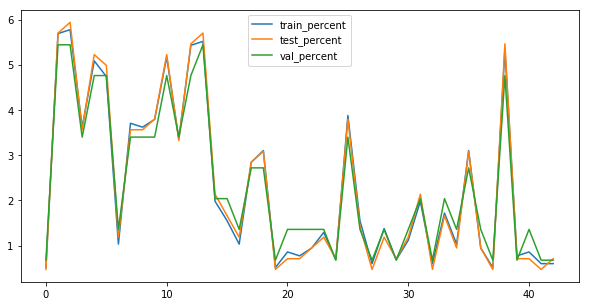

In [27]:
#Get percentages for each set
train_percent = list((list(np.unique(y_train, return_counts=True)[1])/sum(list(np.unique(y_train, return_counts=True)[1])))*100)
test_percent = list((list(np.unique(y_test, return_counts=True)[1])/sum(list(np.unique(y_test, return_counts=True)[1])))*100)
val_percent = list((list(np.unique(y_val, return_counts=True)[1])/sum(list(np.unique(y_val, return_counts=True)[1])))*100)

#turn each percent into dataframe for plotting
columns = (train_percent,test_percent,val_percent)
column_names = ('train_percent','test_percent','val_percent')
        
df = pd.DataFrame({
    'train_percent' : columns[0],
    'test_percent' : columns[1],
    'val_percent' : columns[2]
})

#plotting
df.plot(kind='line', figsize=(10,5))
# plt.legend(loc='best')
# plt.xlabel('Label #')
# plt.ylabel('Percent')
# plt.show()

**Responses appear to be close to being equally split among sets**

<br>
<br>
<br>
<br>
<br>

## 4) Shape & Exploration of Data

In [28]:
#get shape of data
shape = X_train.shape
print('Total Rows:', shape[0])
print('Height:', shape[1])
print('Width:', shape[2])
print('Color Scale:', shape[3], '\n\n|1 = B&W, 3 = RGB|')

Total Rows: 34799
Height: 32
Width: 32
Color Scale: 3 

|1 = B&W, 3 = RGB|


31


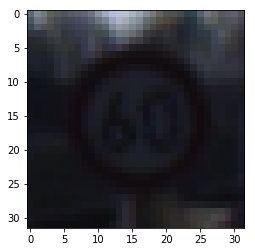

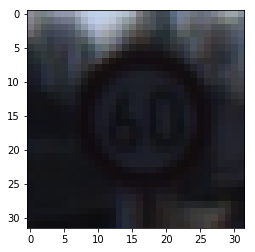

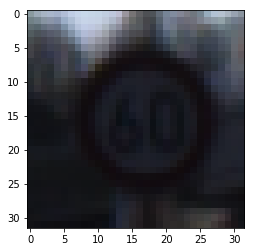

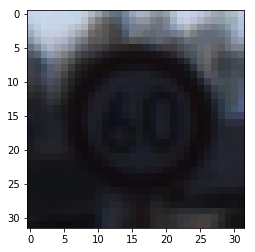

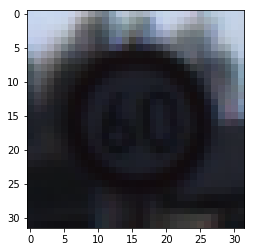

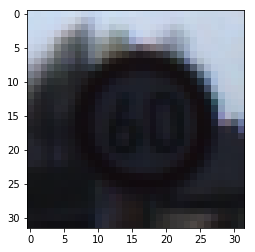

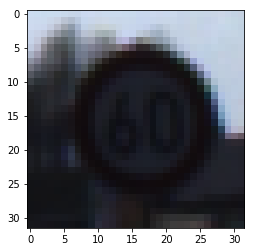

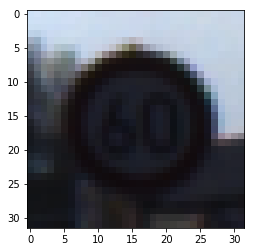

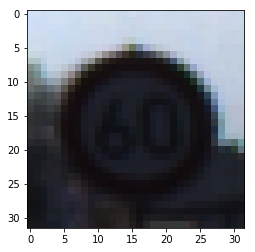

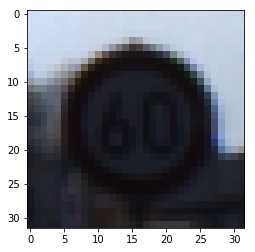

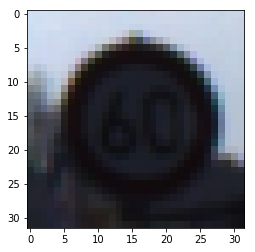

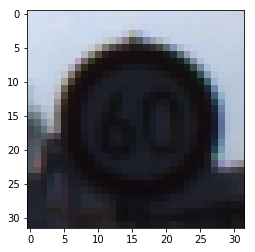

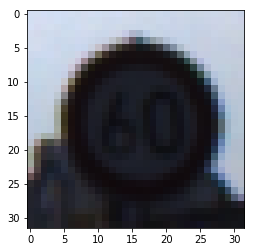

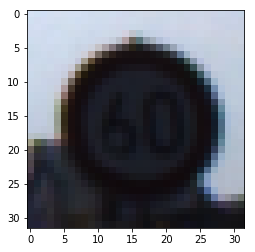

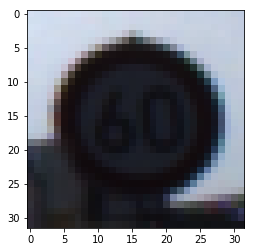

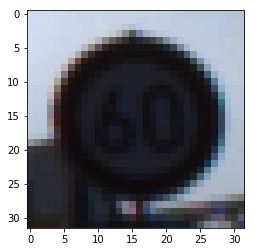

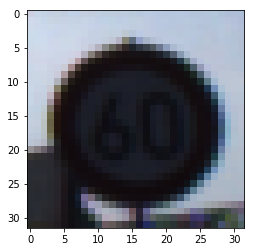

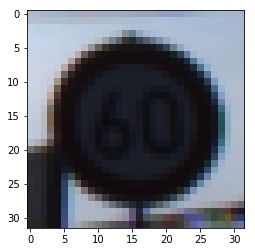

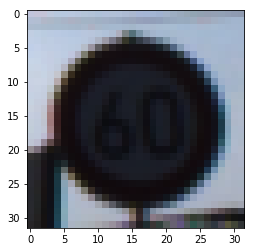

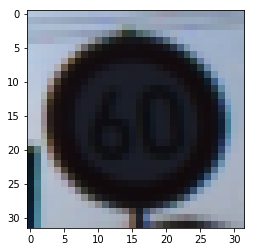

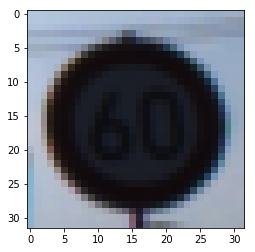

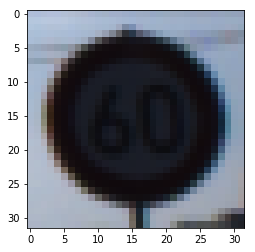

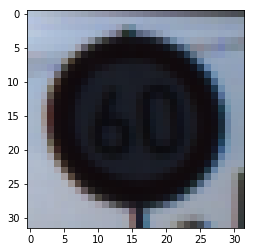

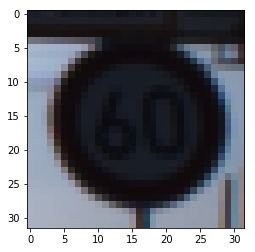

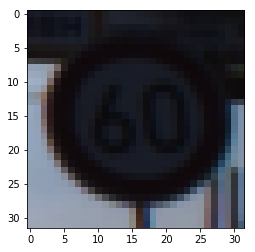

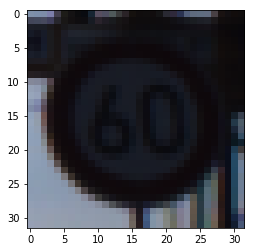

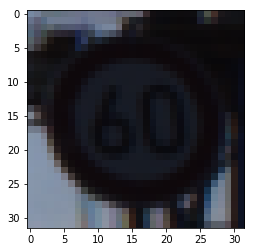

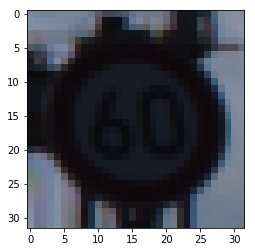

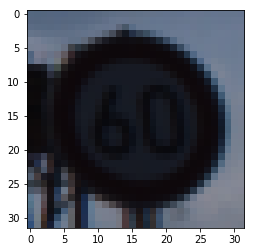

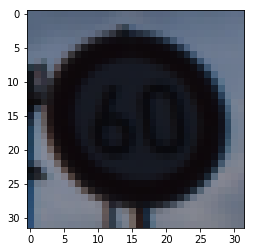

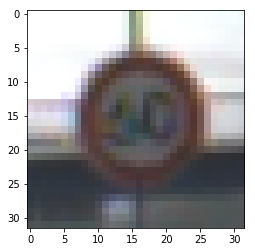

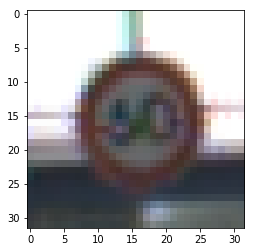

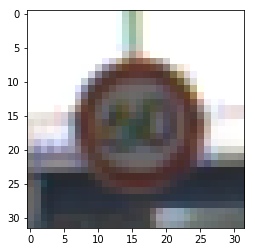

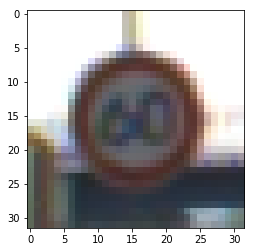

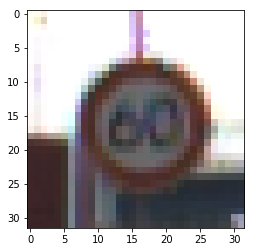

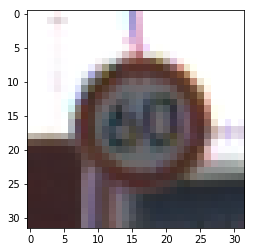

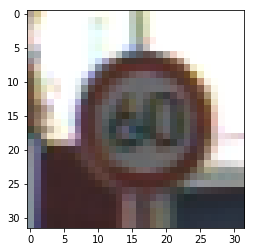

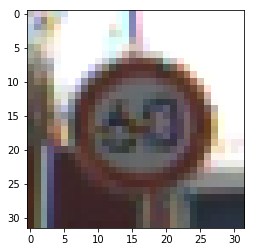

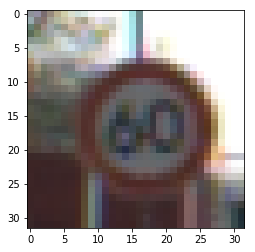

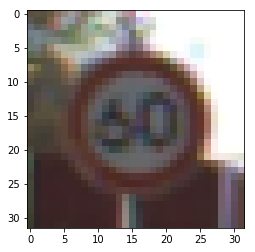

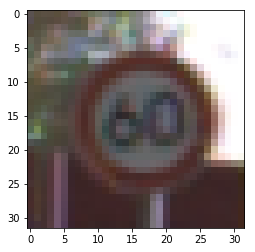

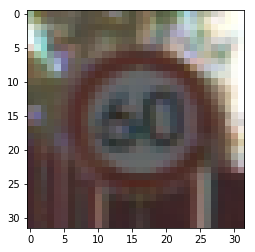

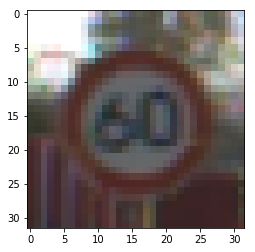

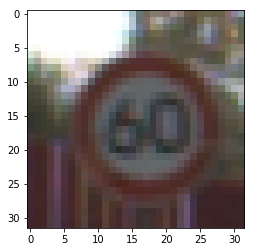

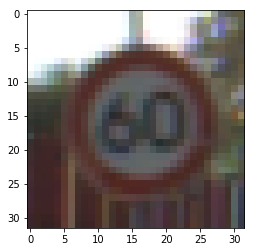

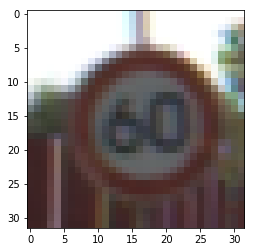

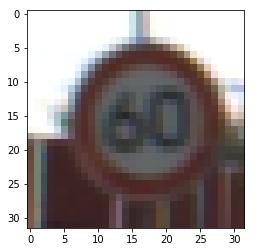

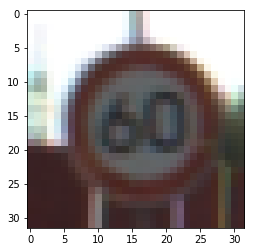

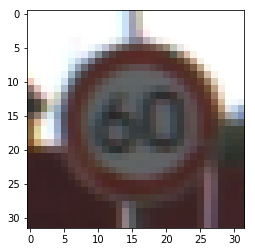

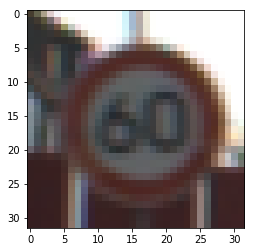

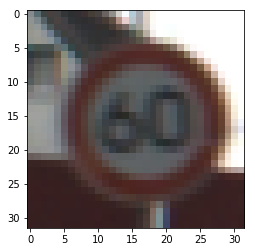

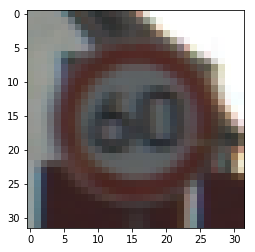

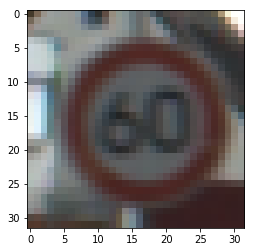

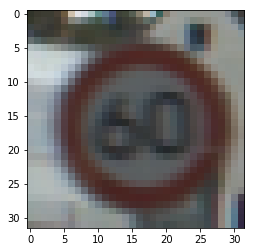

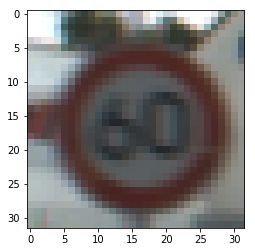

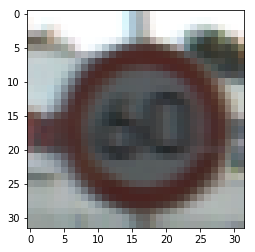

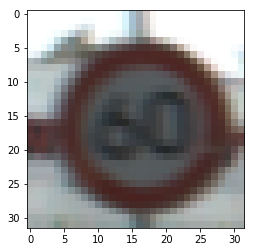

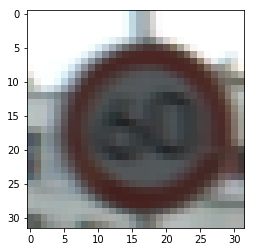

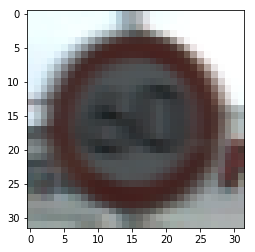

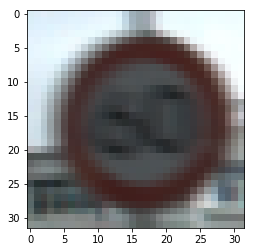

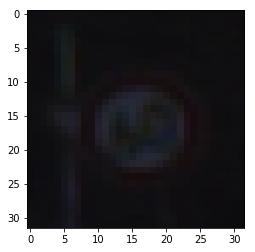

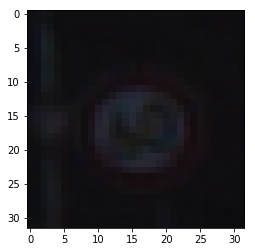

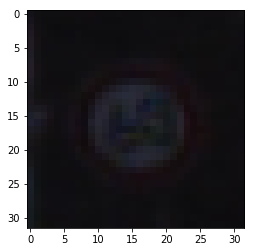

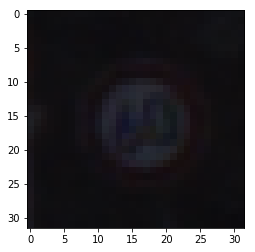

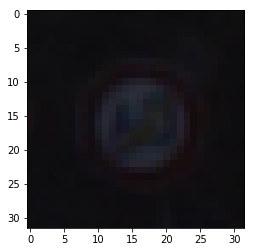

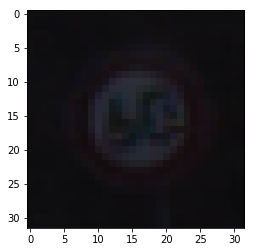

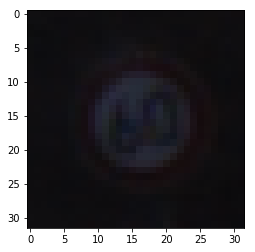

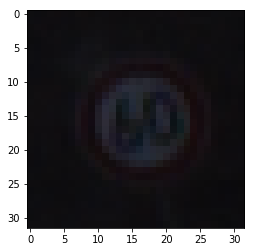

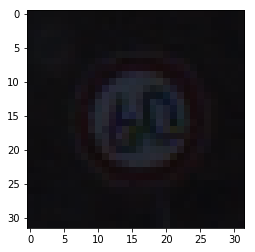

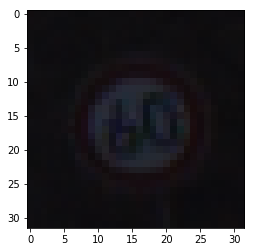

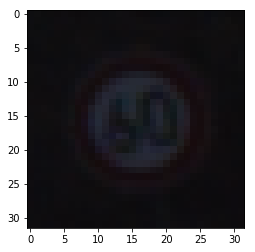

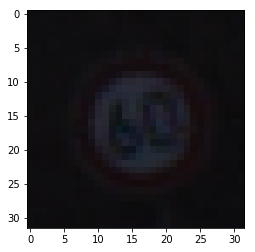

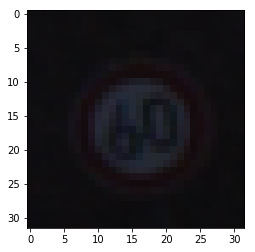

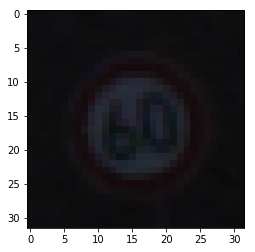

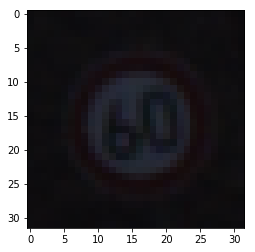

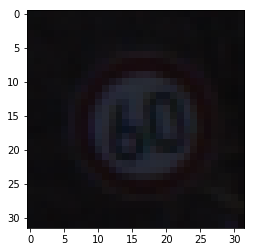

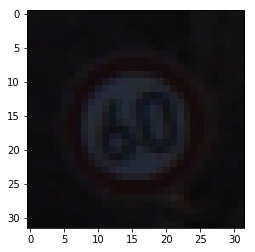

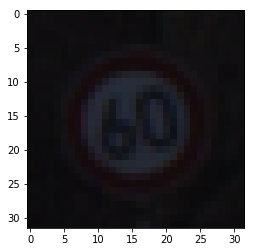

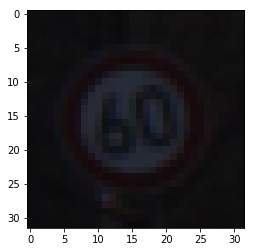

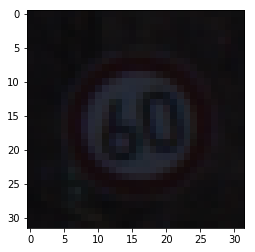

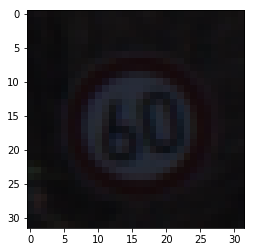

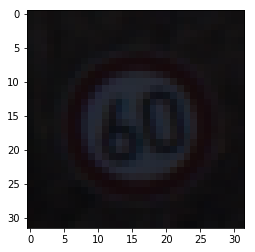

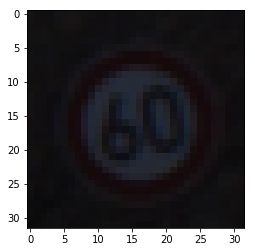

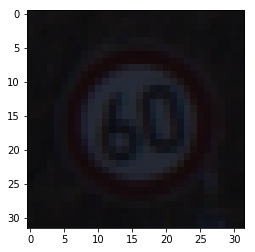

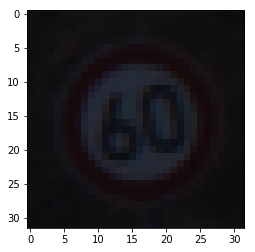

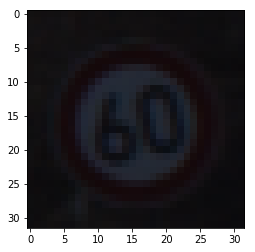

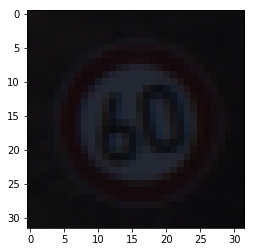

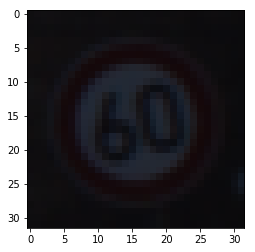

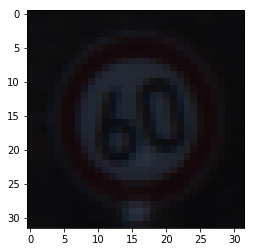

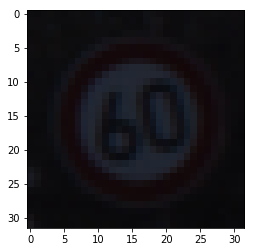

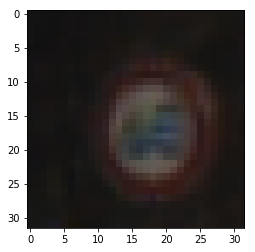

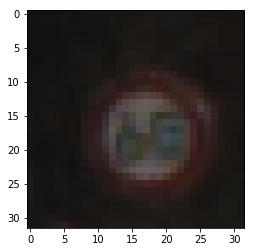

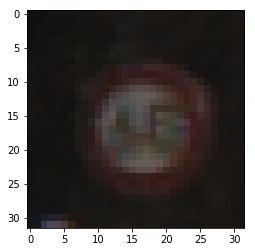

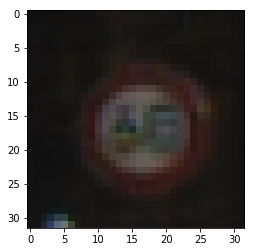

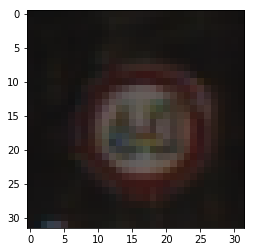

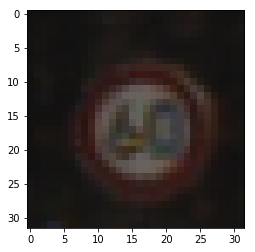

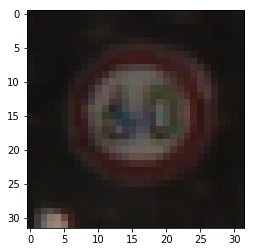

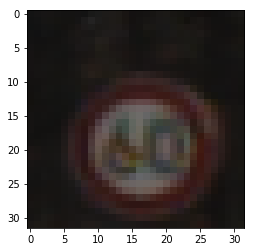

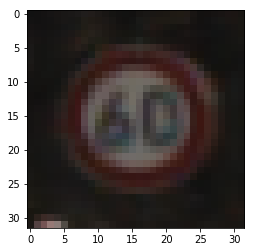

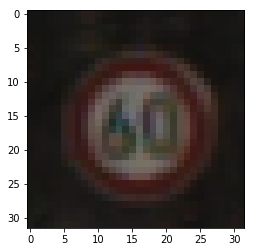

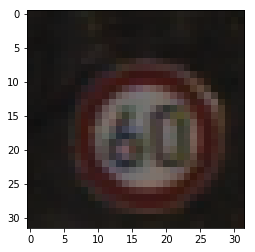

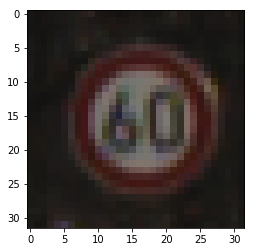

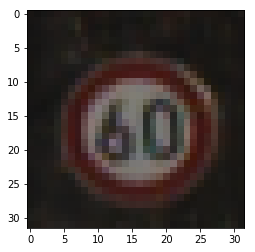

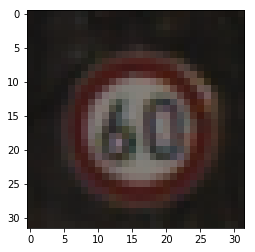

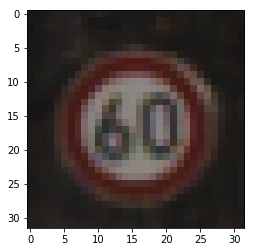

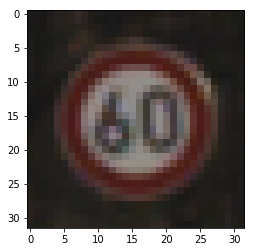

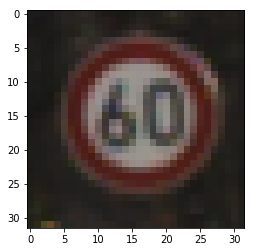

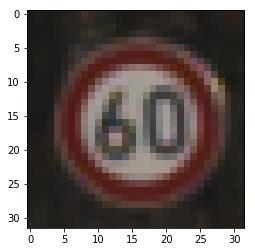

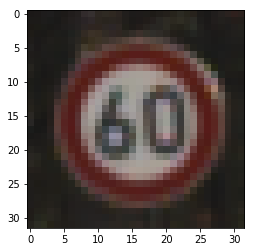

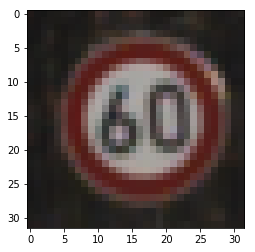

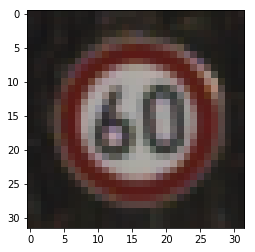

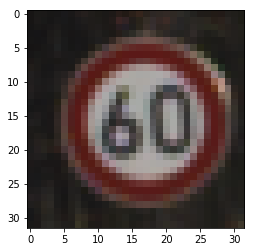

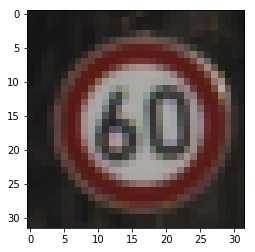

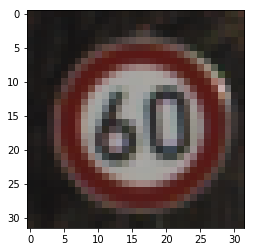

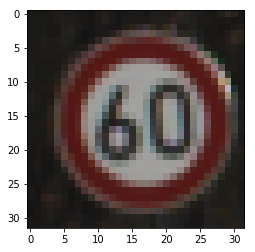

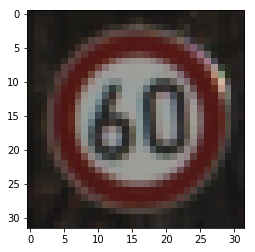

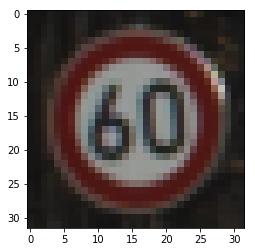

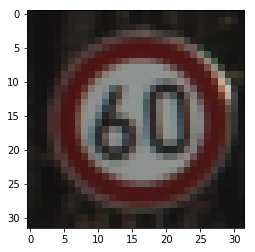

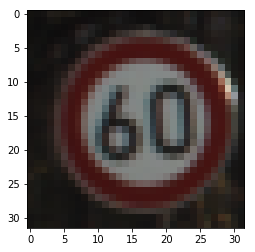

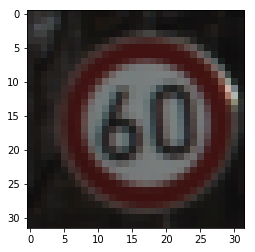

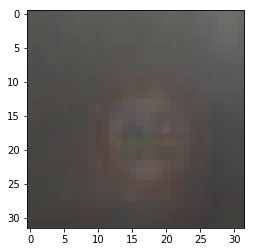

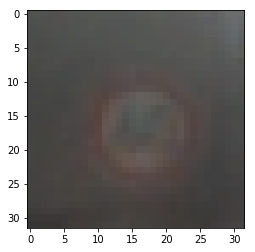

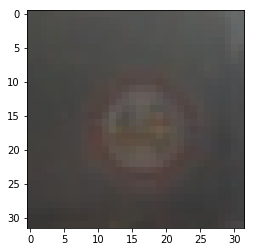

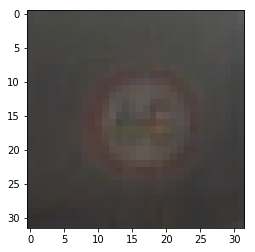

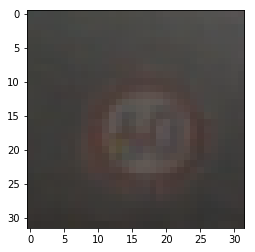

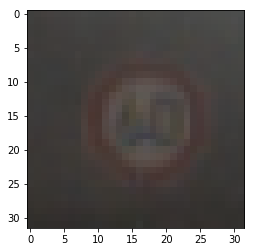

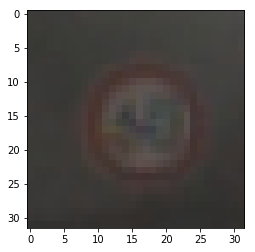

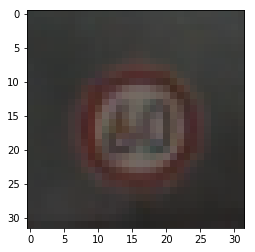

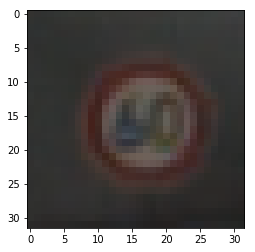

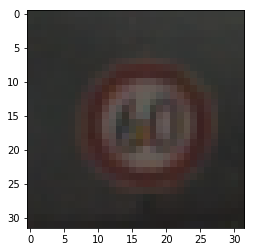

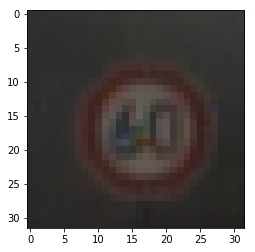

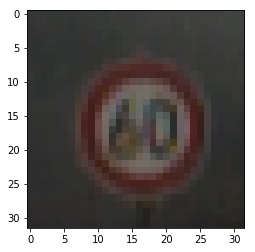

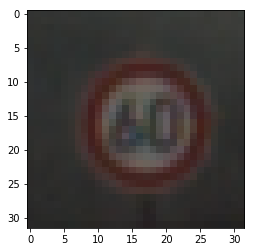

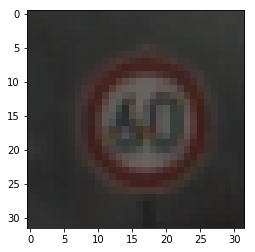

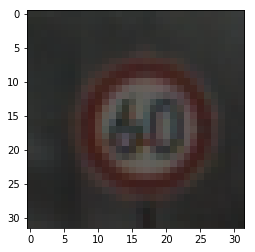

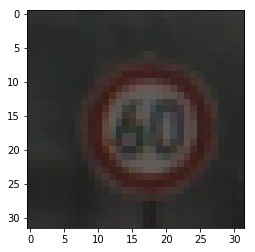

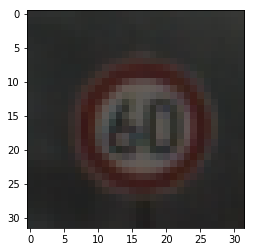

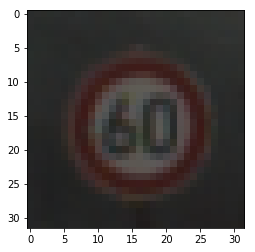

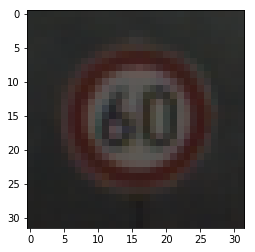

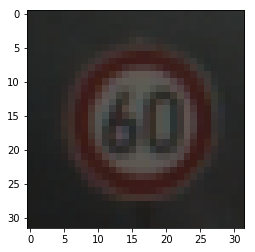

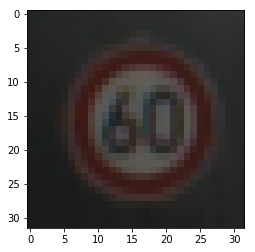

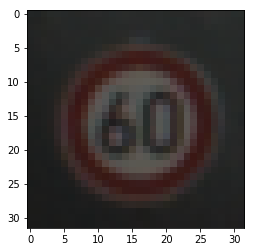

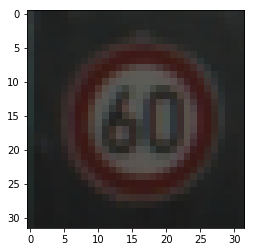

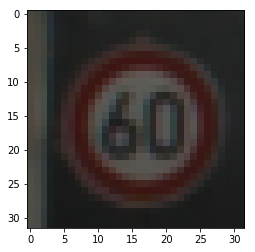

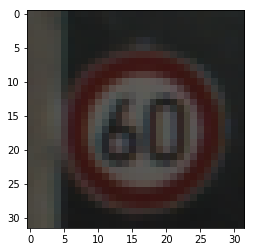

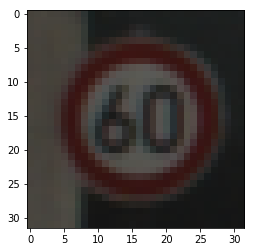

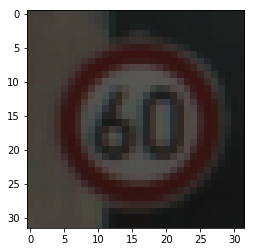

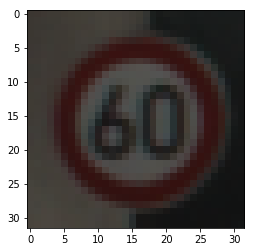

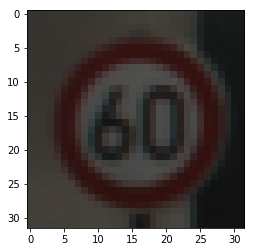

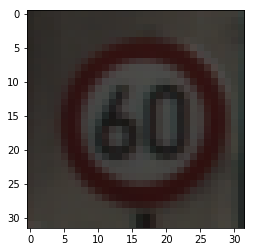

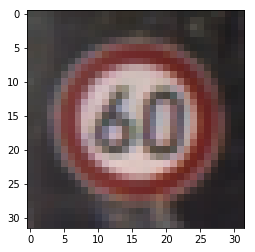

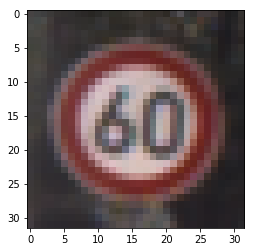

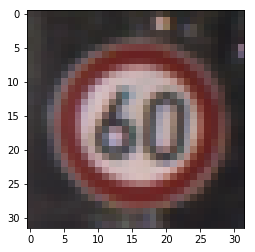

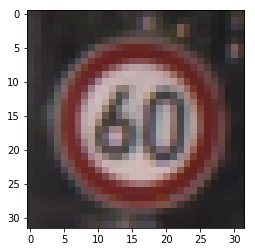

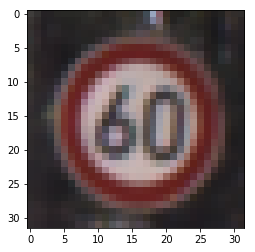

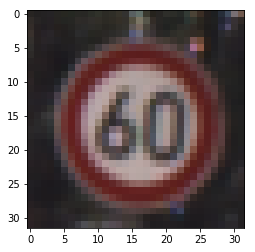

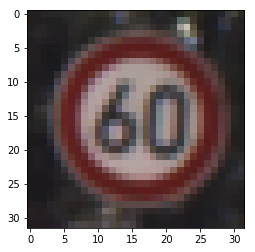

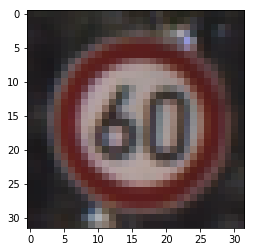

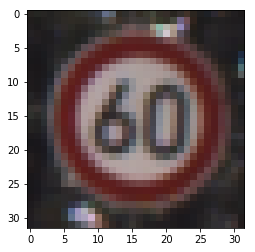

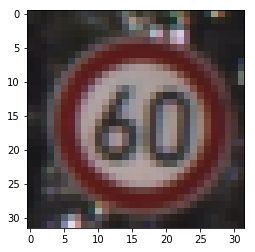

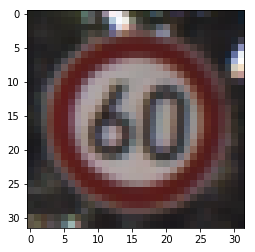

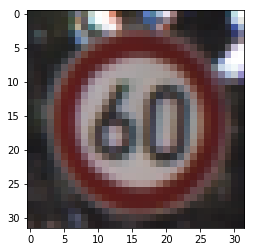

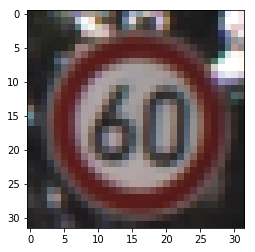

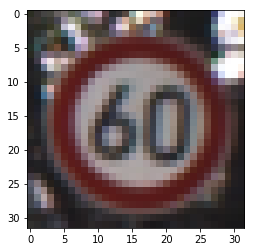

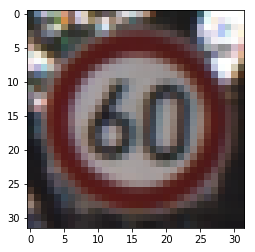

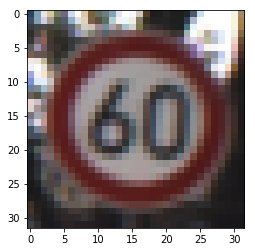

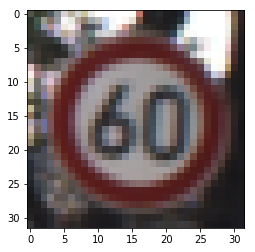

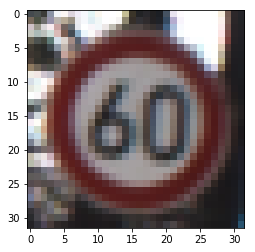

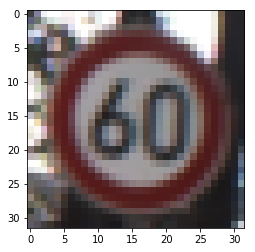

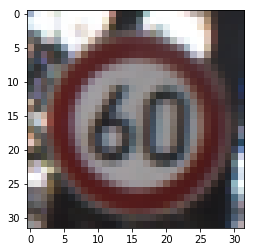

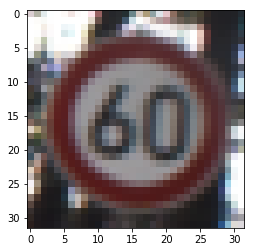

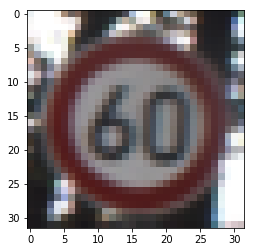

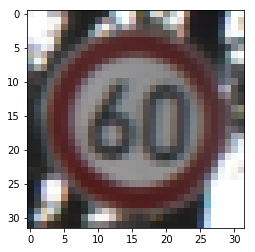

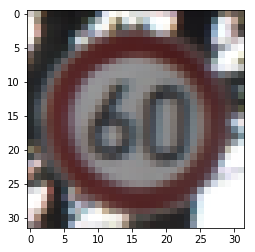

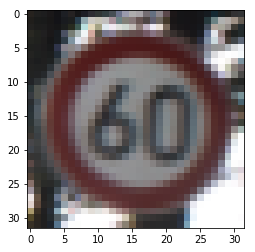

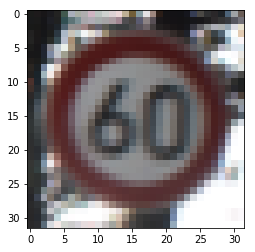

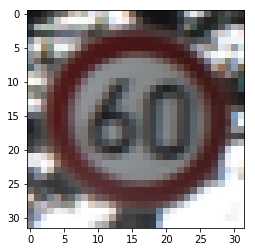

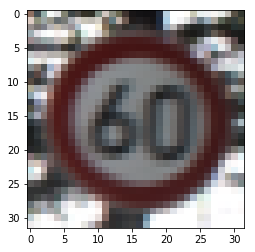

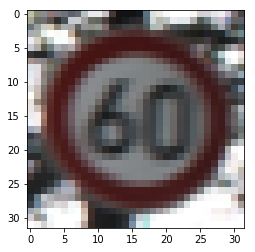

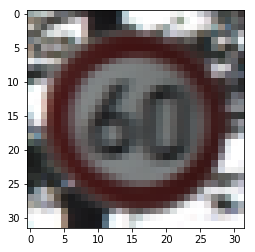

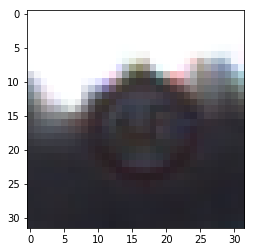

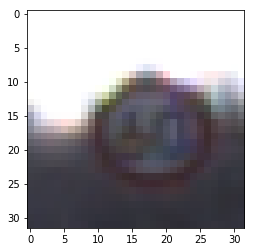

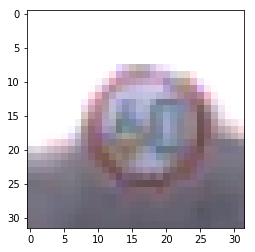

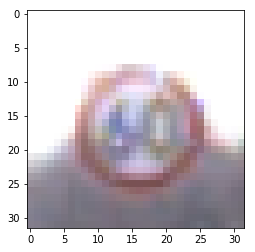

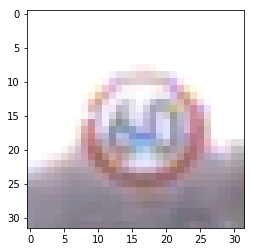

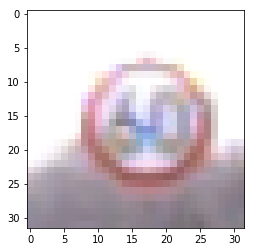

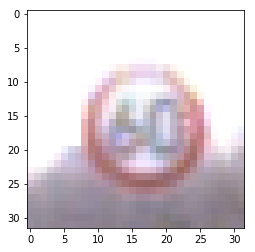

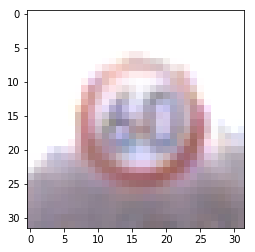

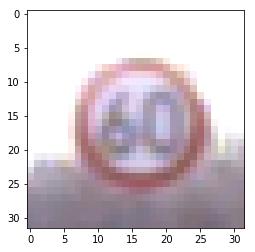

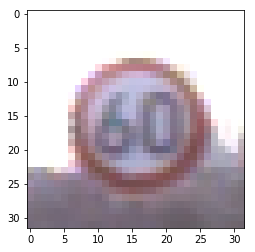

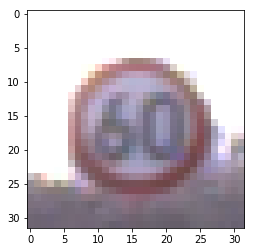

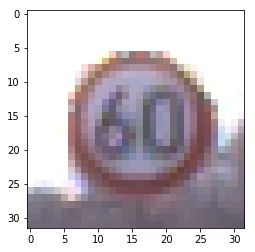

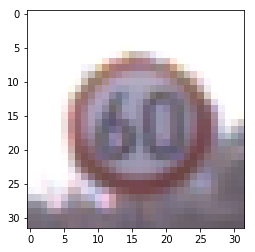

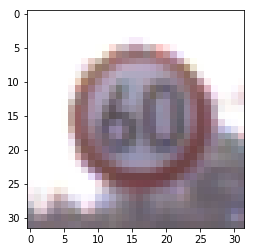

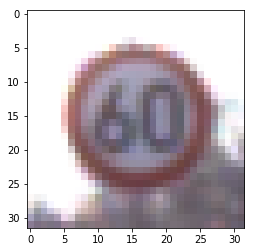

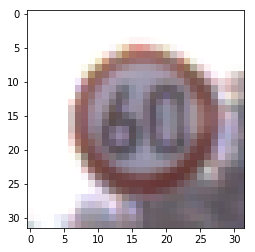

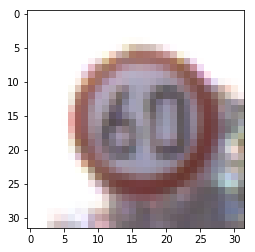

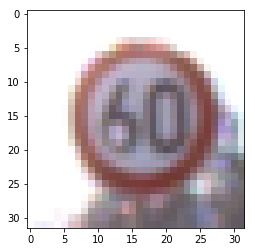

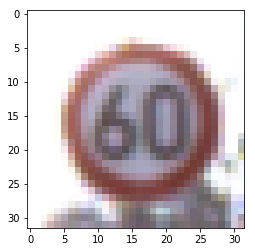

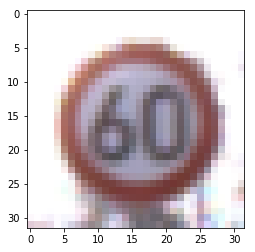

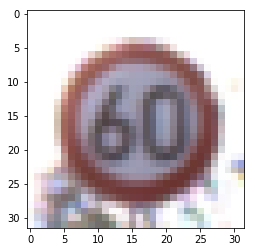

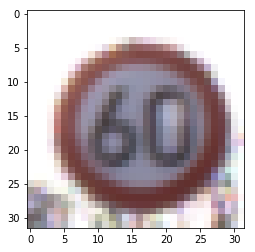

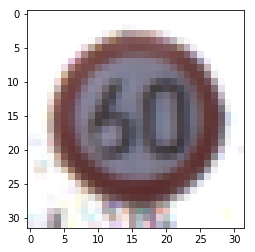

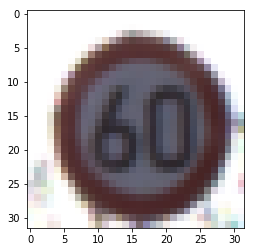

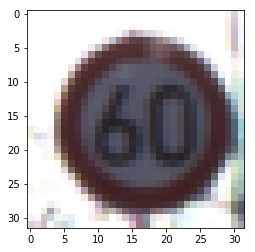

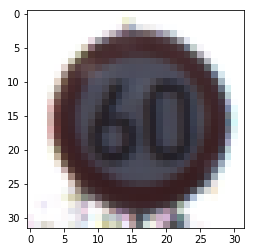

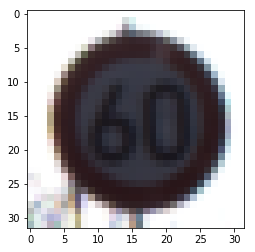

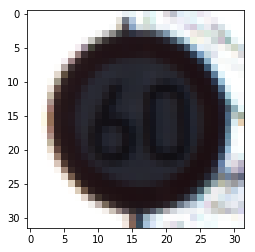

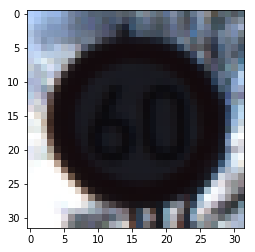

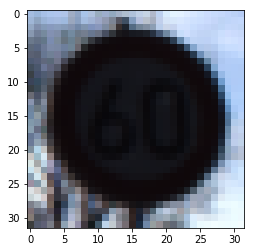

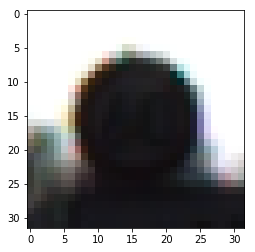

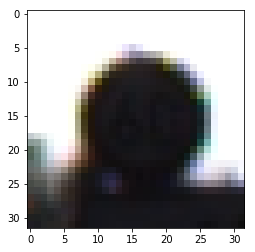

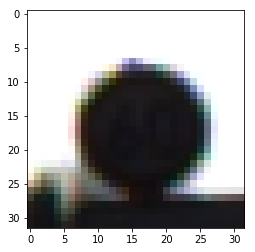

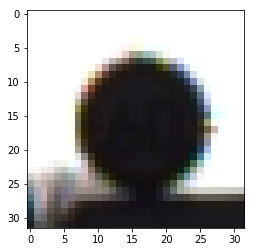

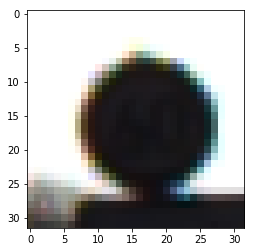

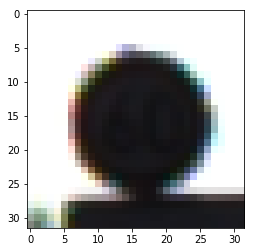

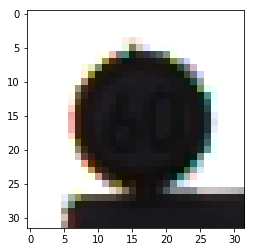

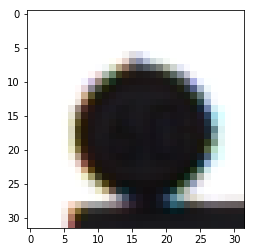

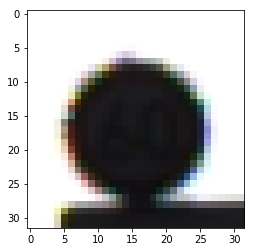

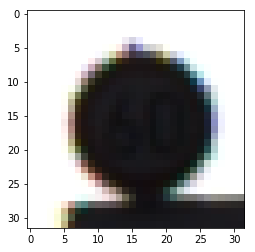

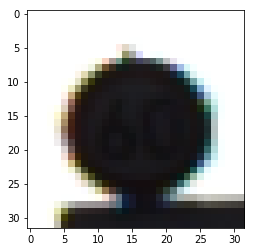

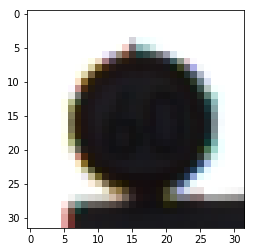

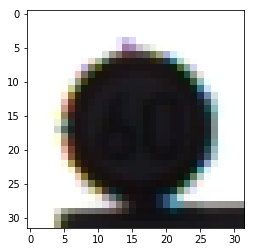

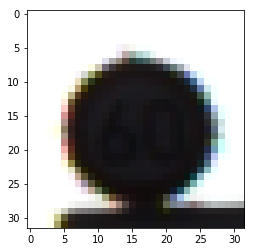

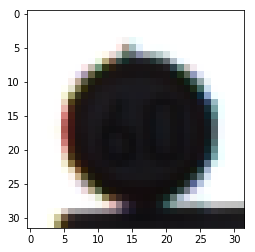

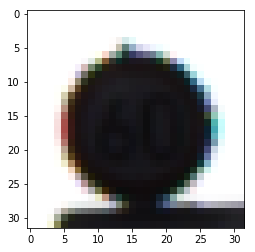

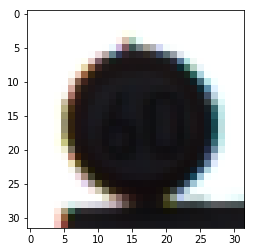

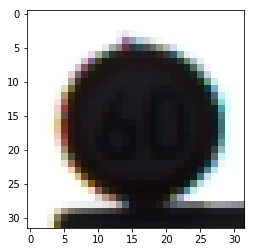

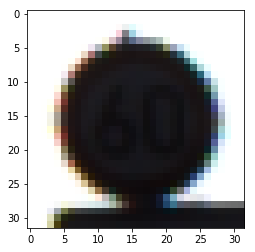

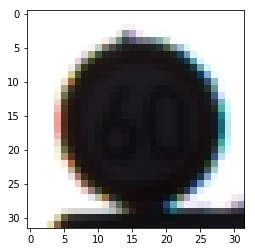

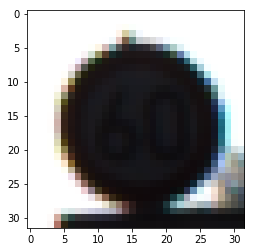

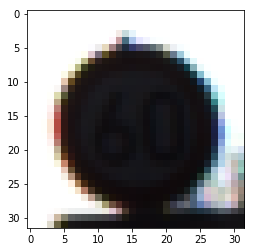

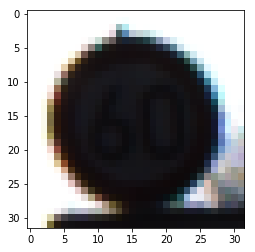

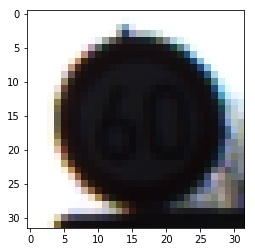

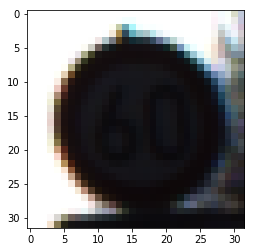

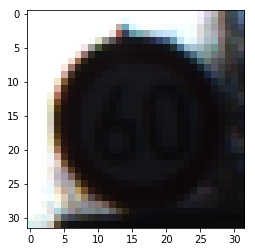

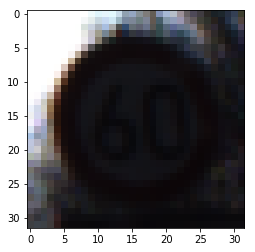

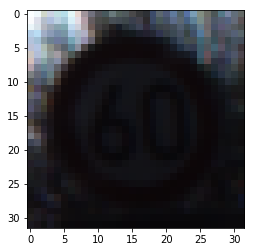

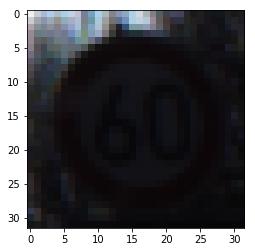

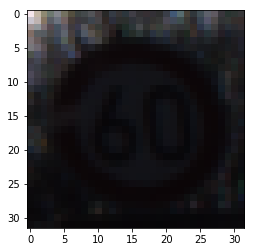

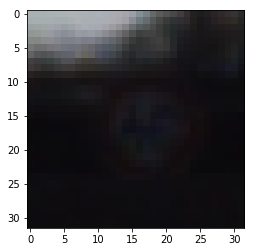

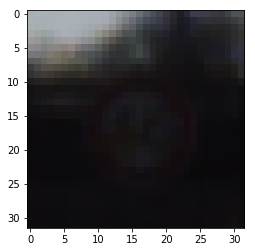

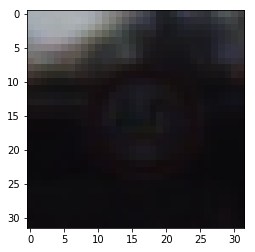

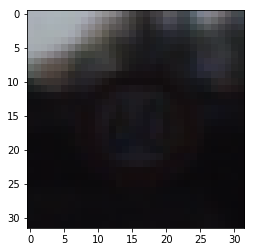

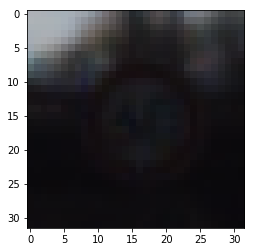

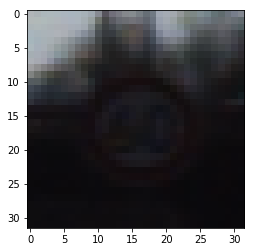

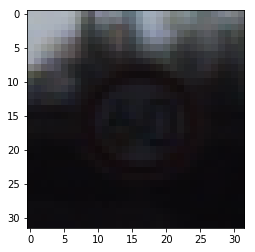

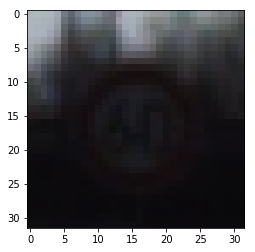

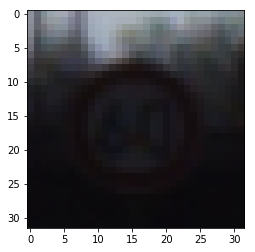

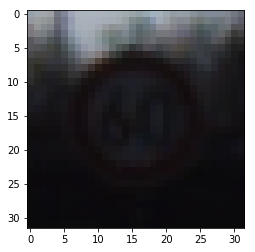

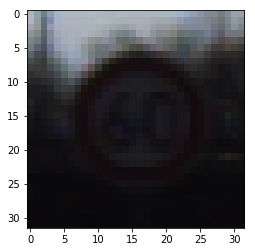

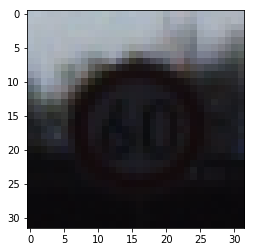

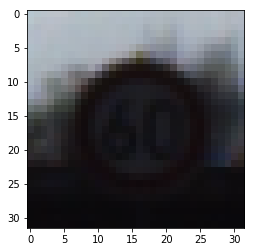

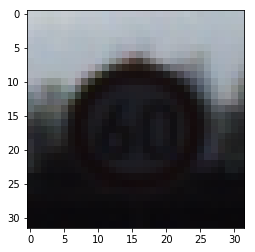

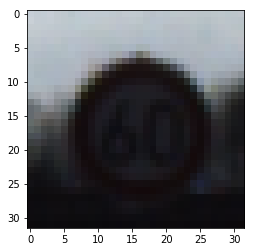

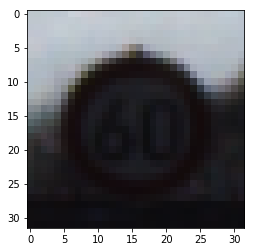

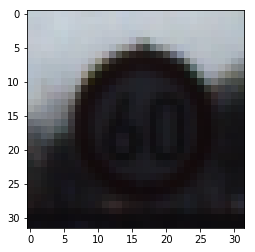

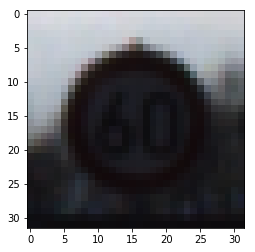

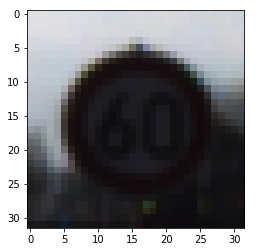

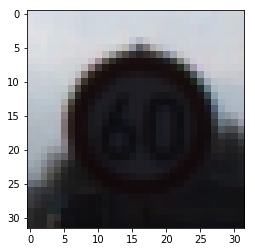

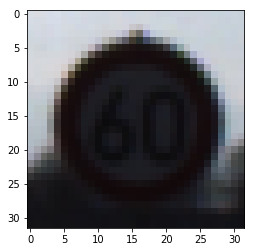

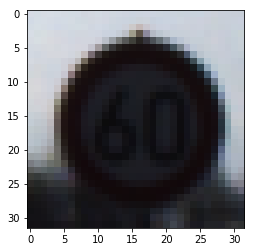

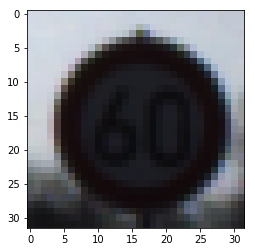

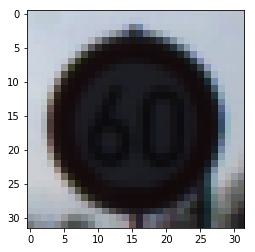

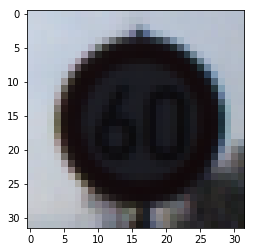

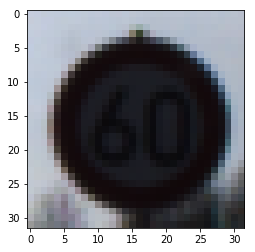

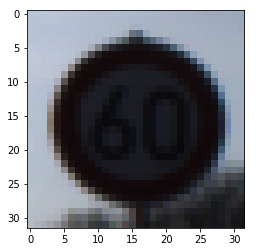

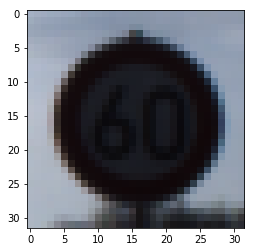

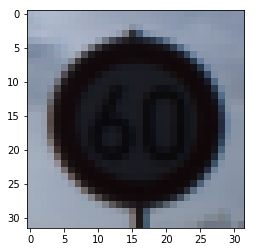

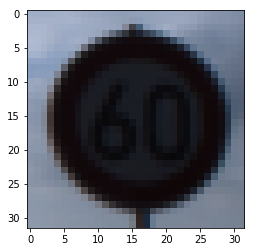

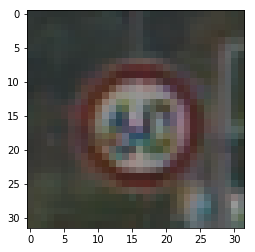

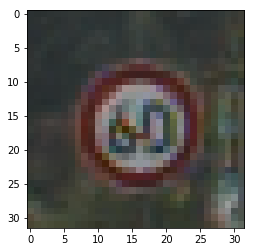

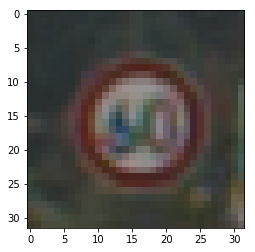

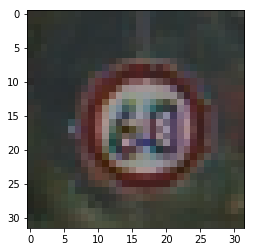

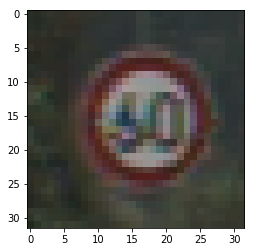

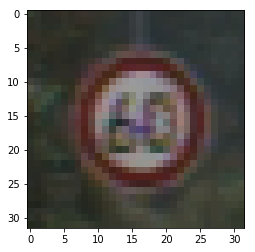

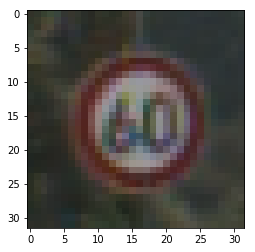

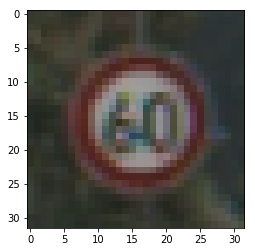

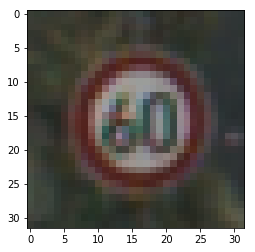

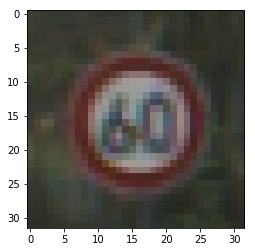

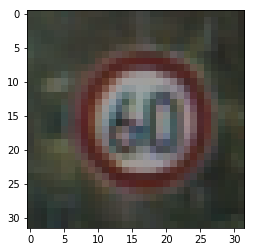

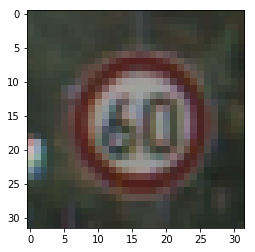

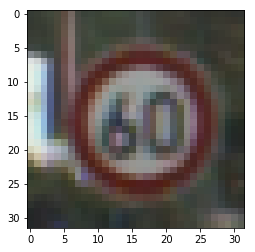

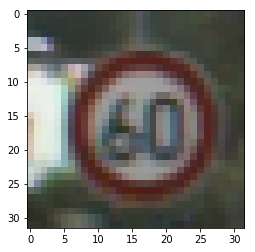

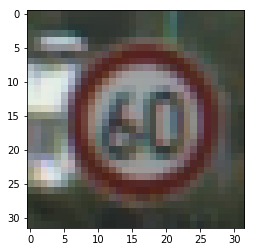

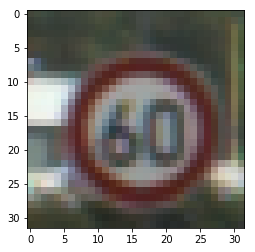

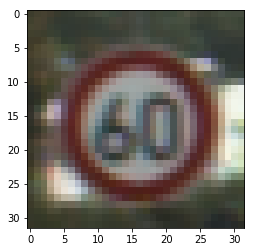

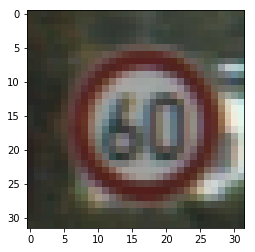

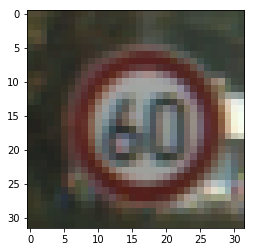

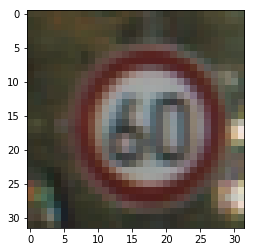

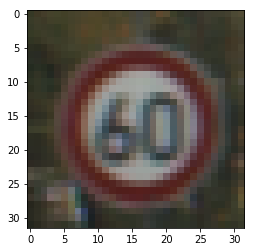

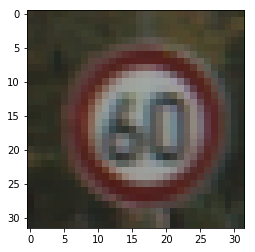

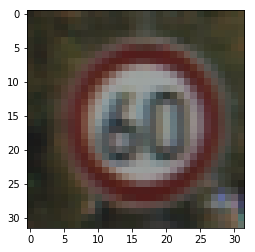

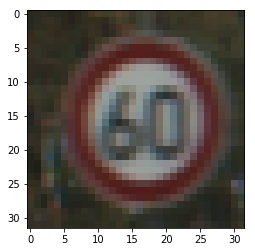

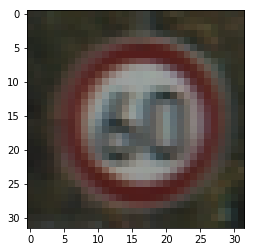

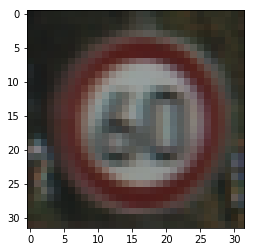

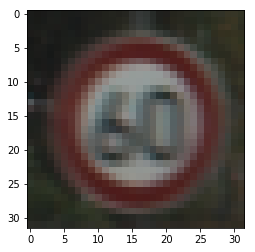

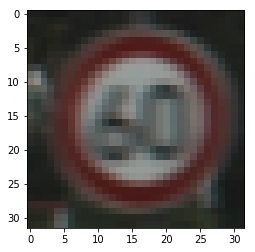

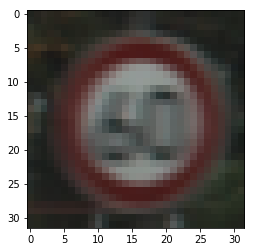

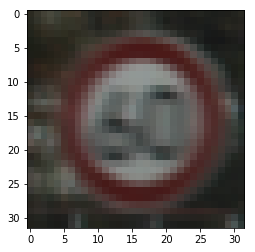

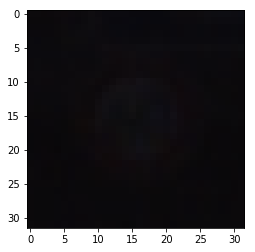

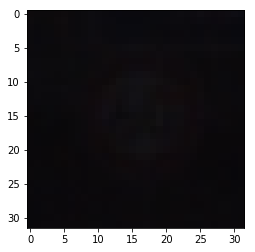

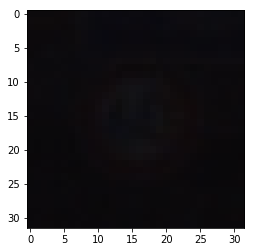

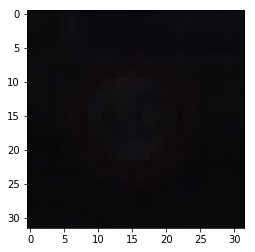

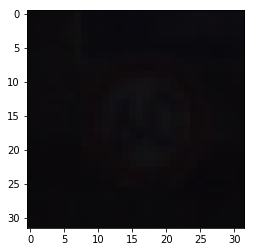

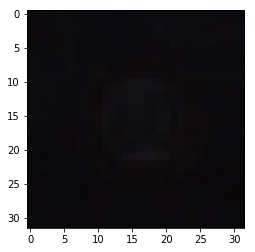

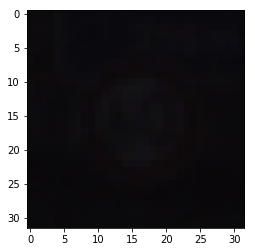

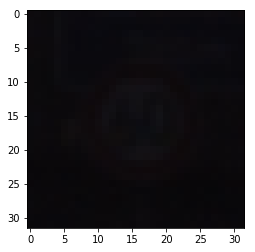

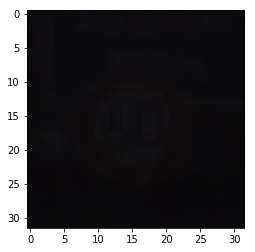

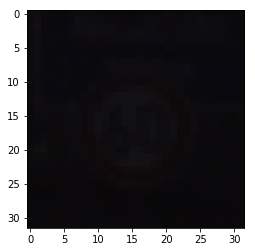

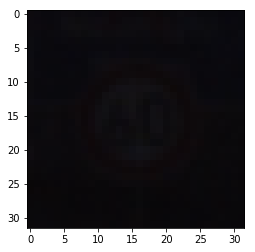

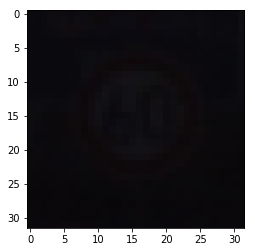

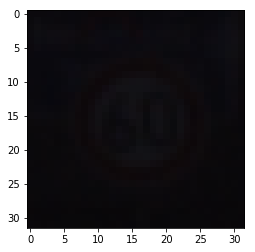

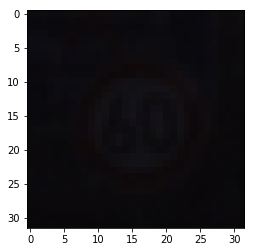

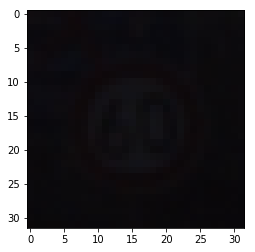

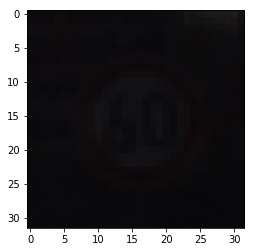

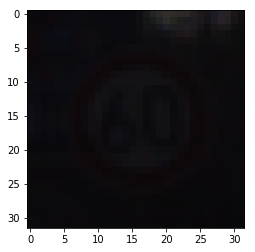

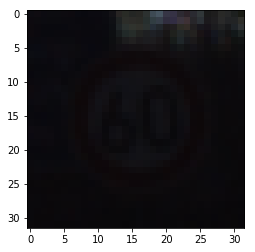

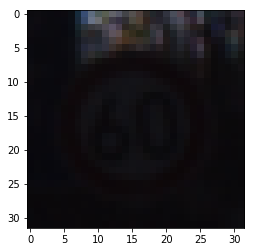

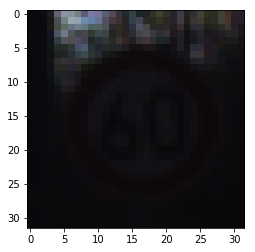

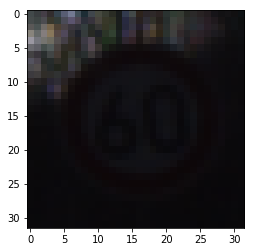

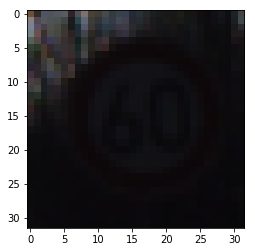

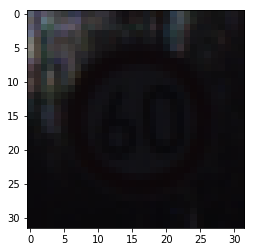

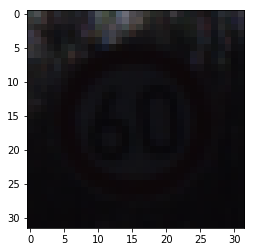

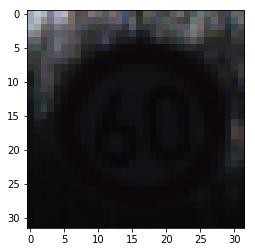

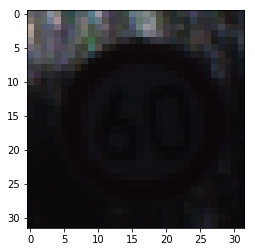

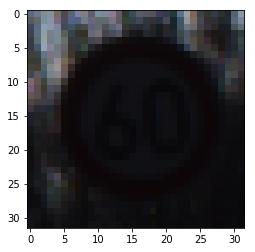

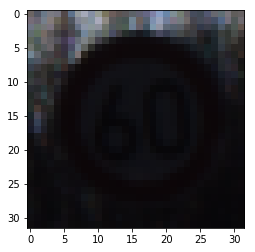

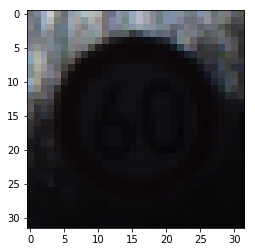

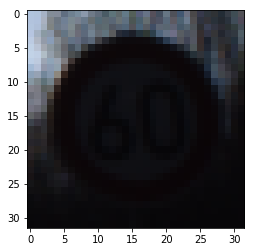

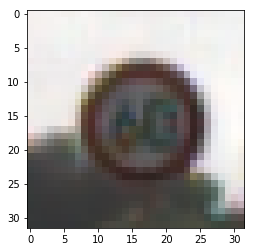

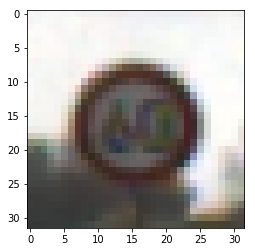

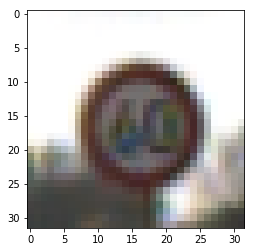

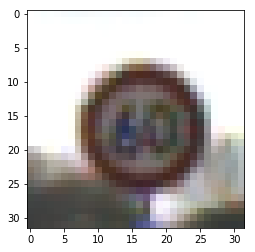

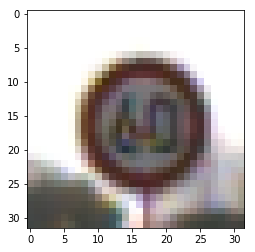

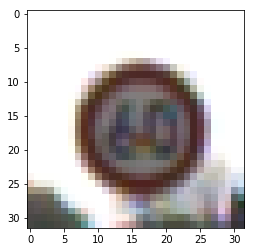

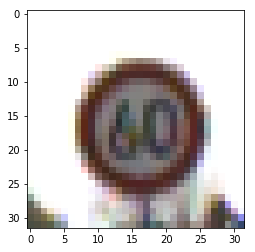

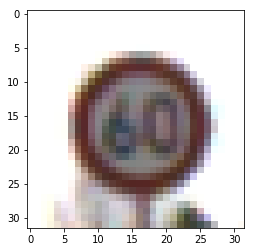

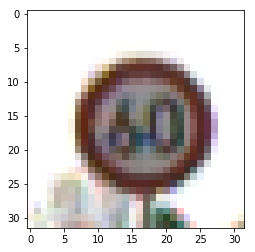

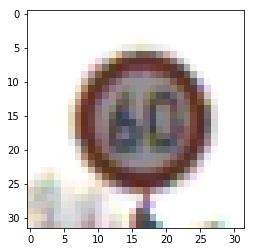

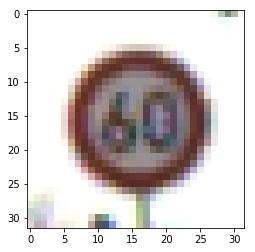

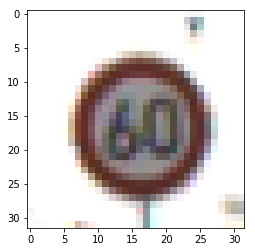

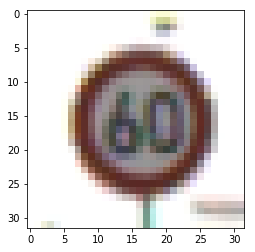

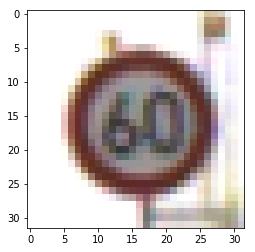

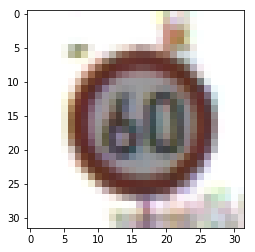

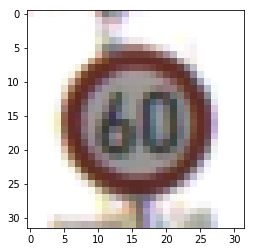

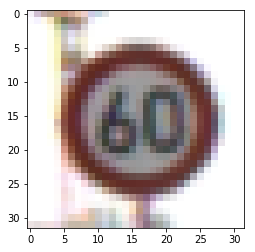

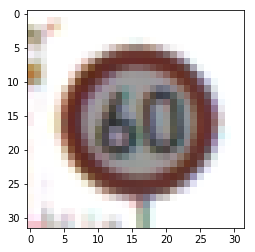

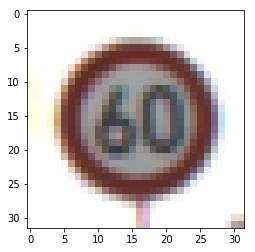

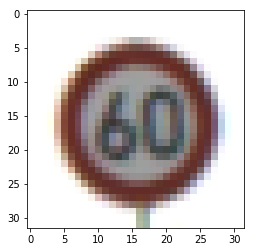

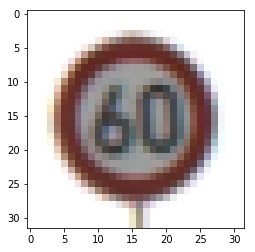

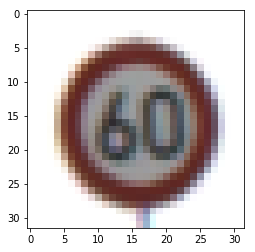

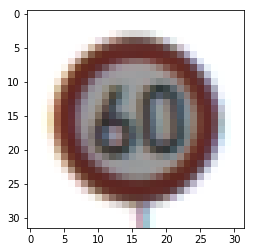

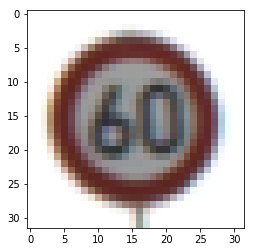

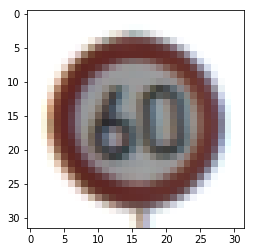

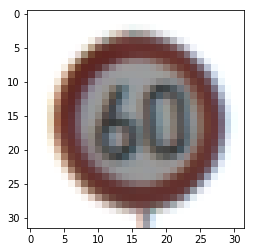

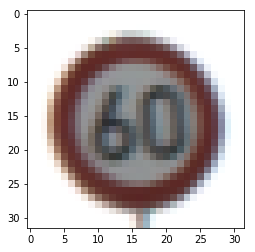

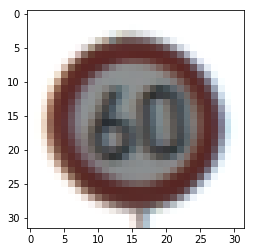

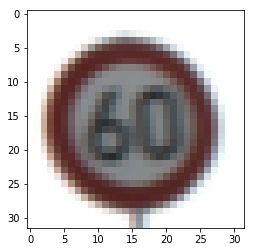

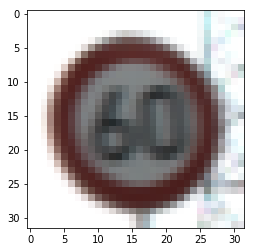

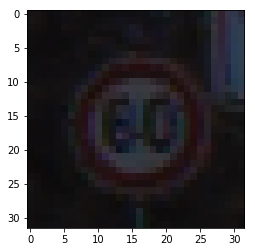

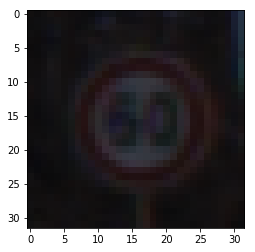

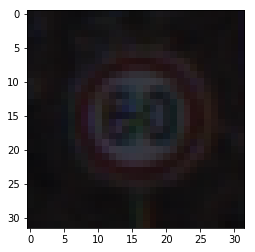

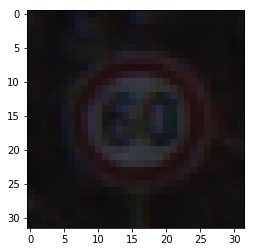

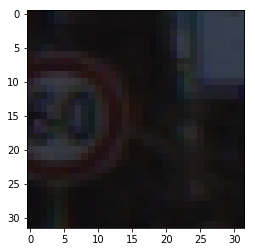

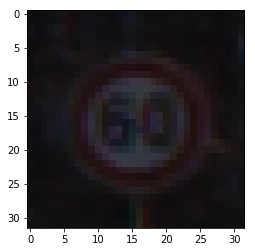

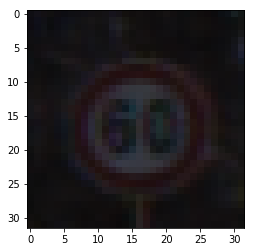

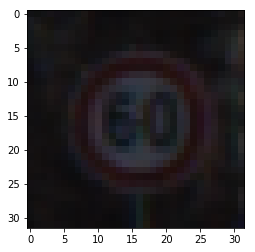

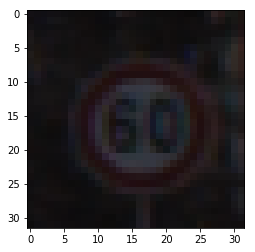

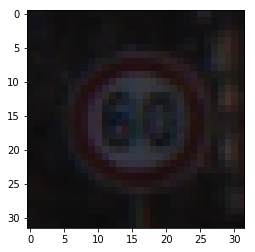

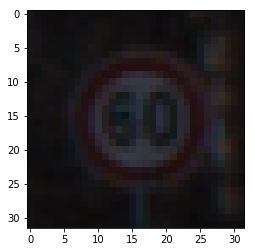

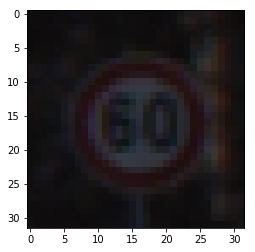

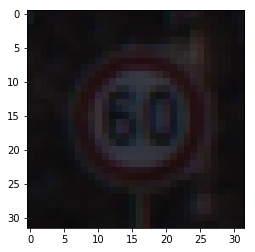

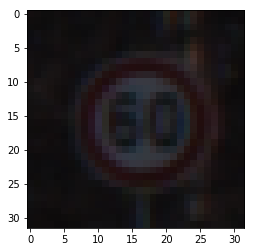

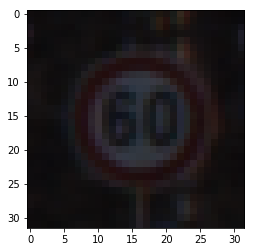

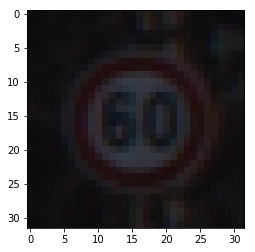

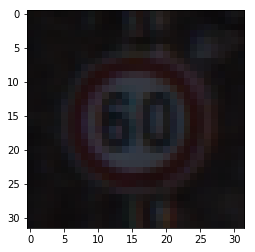

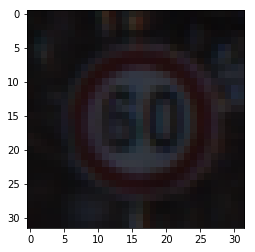

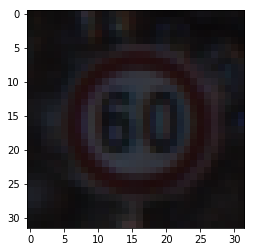

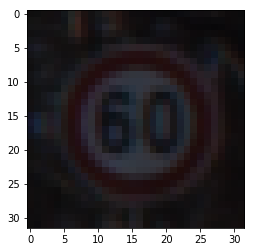

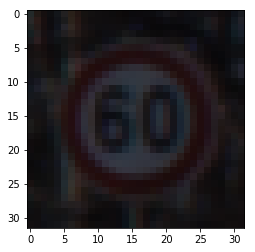

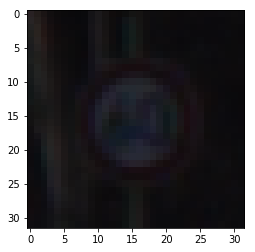

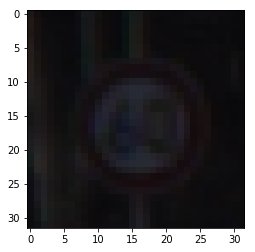

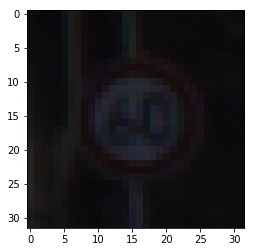

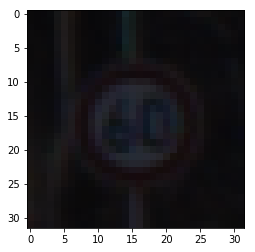

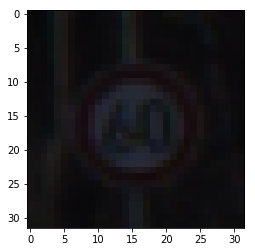

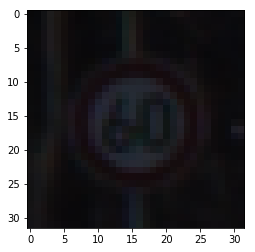

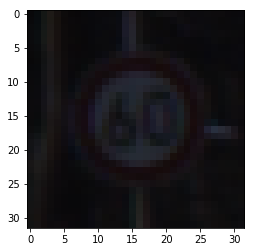

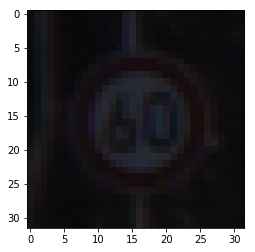

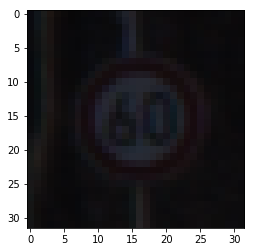

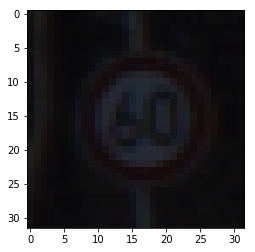

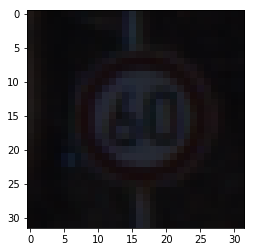

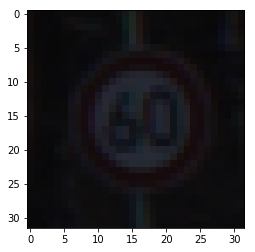

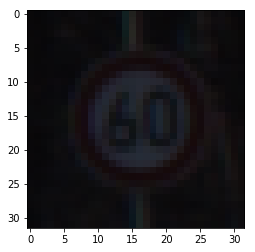

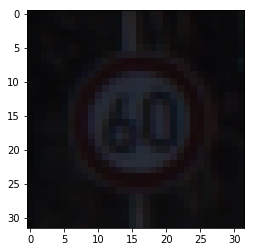

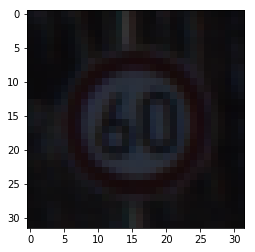

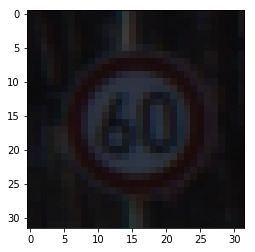

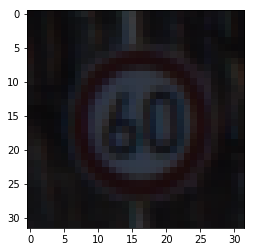

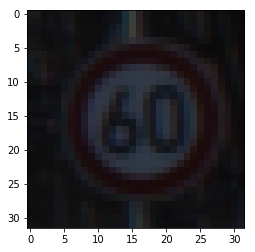

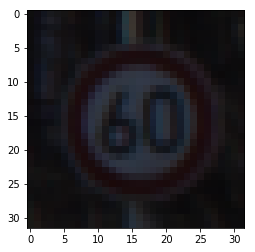

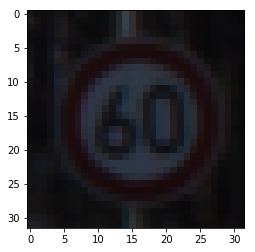

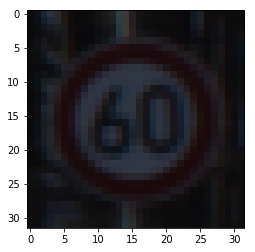

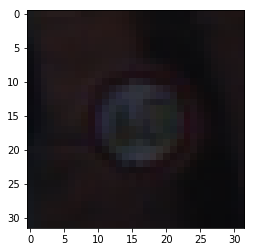

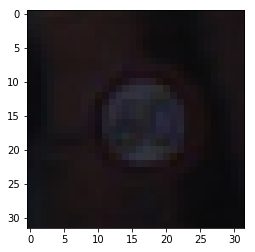

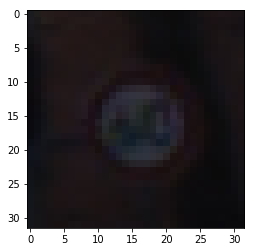

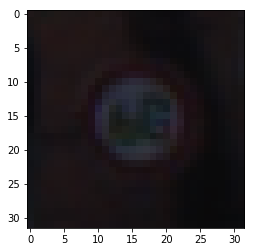

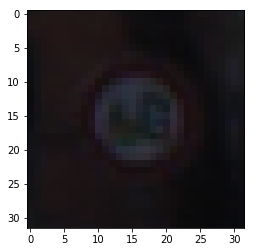

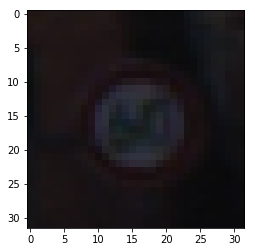

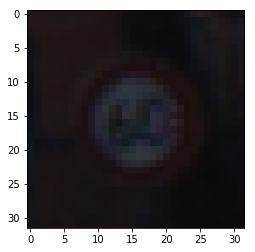

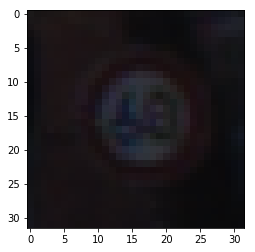

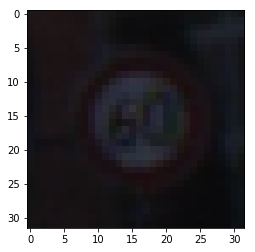

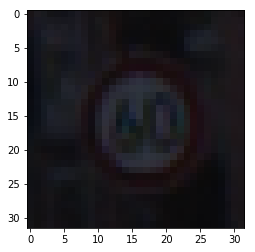

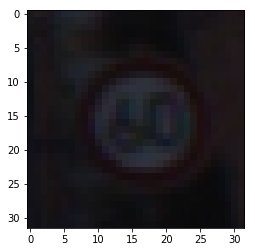

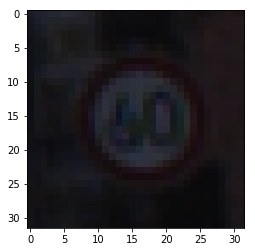

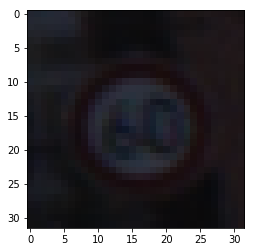

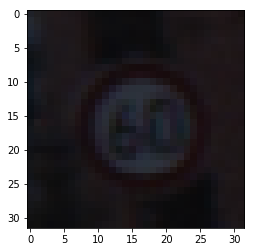

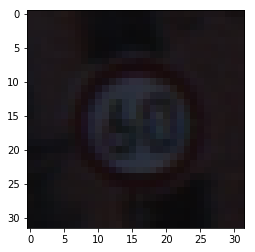

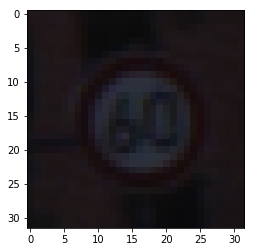

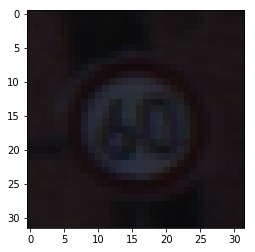

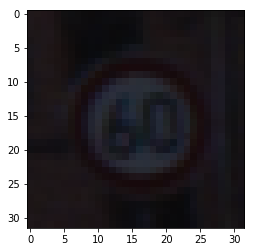

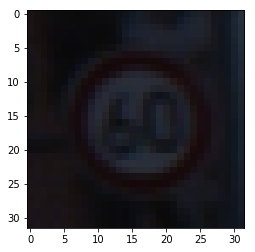

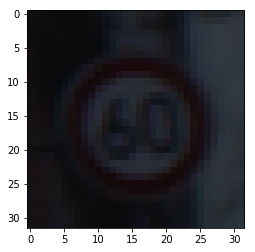

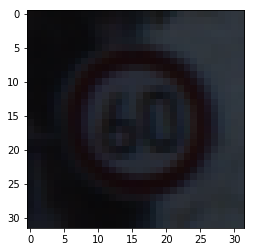

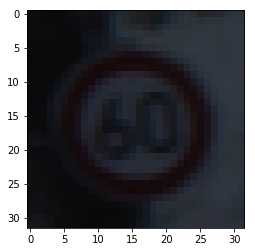

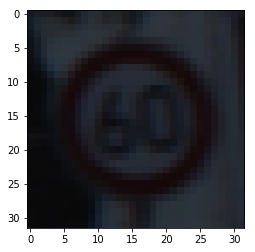

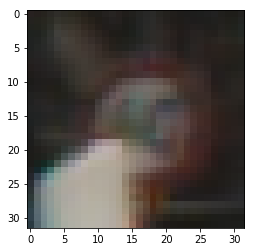

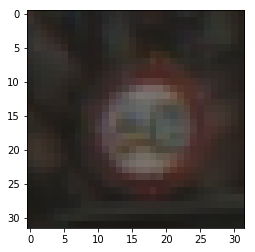

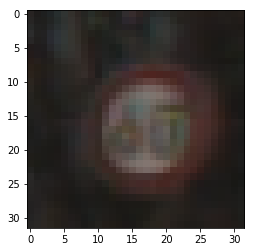

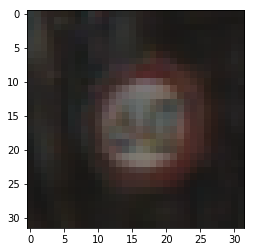

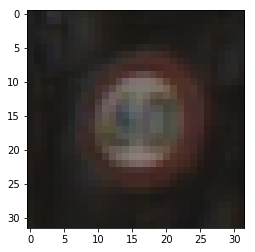

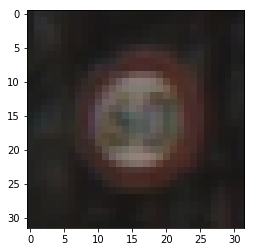

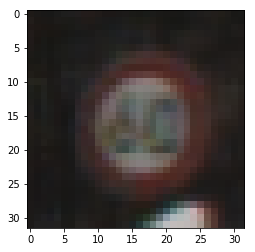

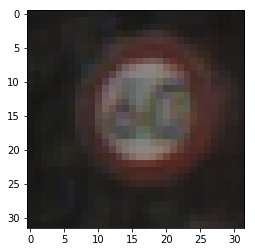

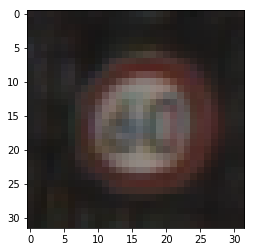

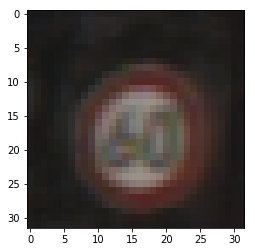

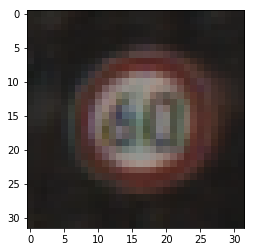

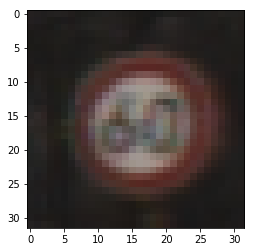

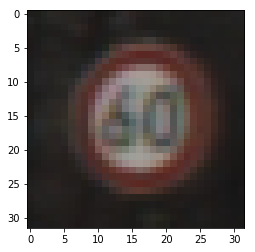

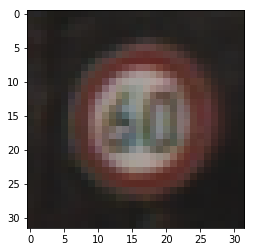

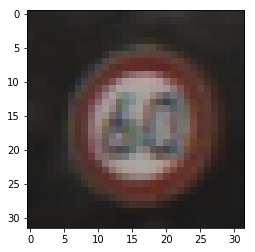

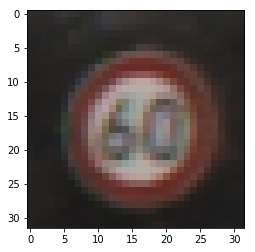

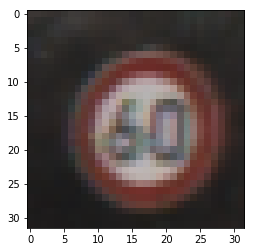

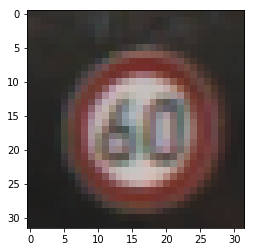

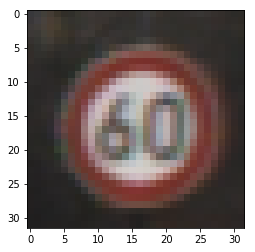

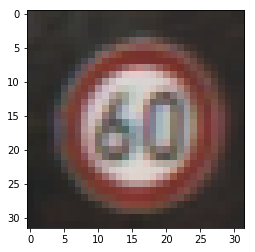

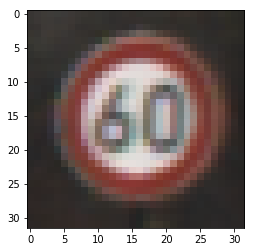

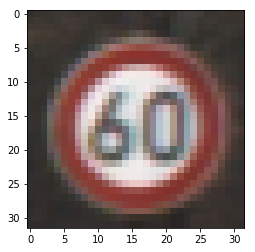

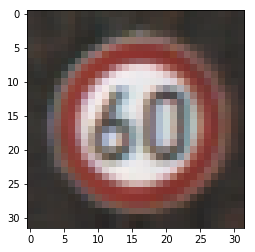

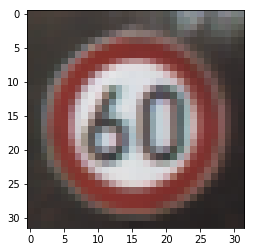

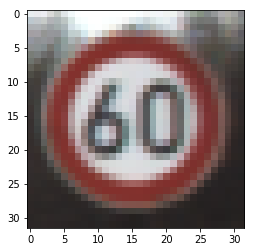

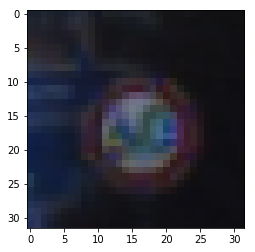

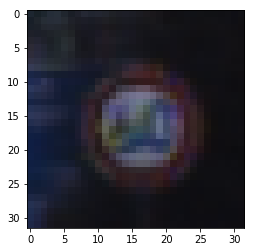

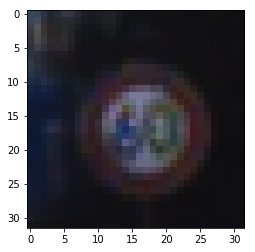

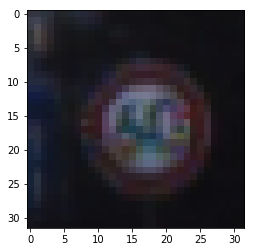

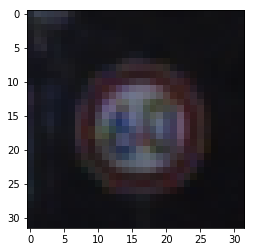

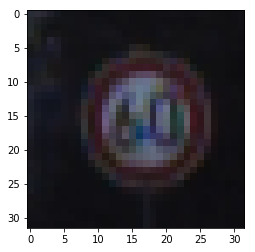

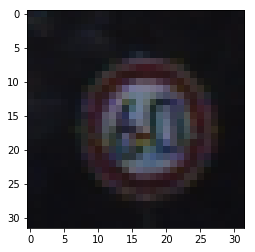

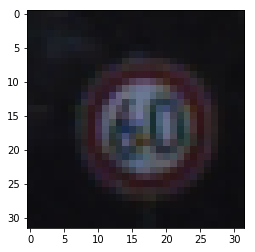

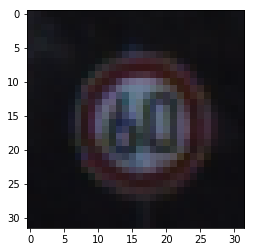

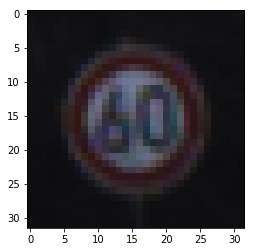

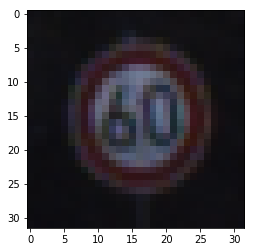

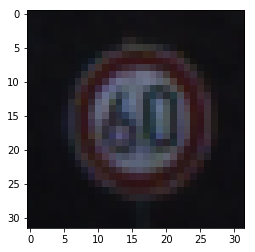

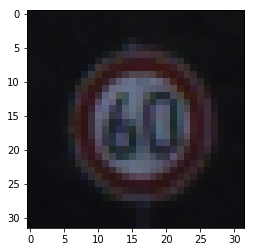

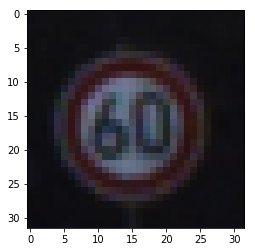

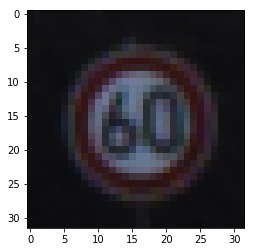

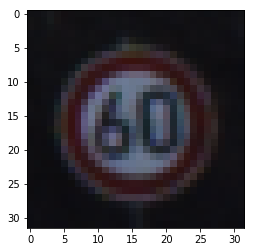

In [38]:
#display picture
print(y_train[605])

for i in X_train[6000:6500]:
    
    plt.imshow(i)
    plt.show()

In [9]:
#The data is organized by response
y_train[150:250]

array([41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41, 41,
       41, 41, 41, 41, 41, 41, 41, 41, 41, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31],
      dtype=uint8)

34


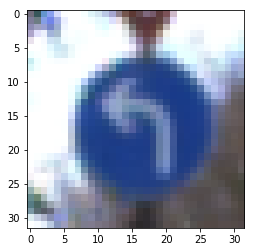

In [10]:
#reshuffle data
X_train, y_train = shuffle(X_train,y_train)

#display shuffled picture
print(y_train[600])
plt.imshow(X_train[600])
plt.show()

<br>
<br>
<br>
<br>

## 5) Turn Images to Grayscale

Grayscale images create inherently less complicated models and save processing time

In [11]:
def to_black_and_white(X_data):
    """Takes YCbCr (not RGB) values and converts the values to grayscale. Additionally, convernts 3 chanels to 1"""
    
    #YCbCr to scale
    X_data = 0.299 * X_data[:, :, :, 0] + 0.587 * X_data[:, :, :, 1] + 0.114 * X_data[:, :, :, 2]

    #normalize features to be in [0, 1]
    X_data = (X_data / 255.).astype(np.float32)

    # Add a single scale channel
    X_data = X_data.reshape(X_data.shape + (1,))
    
    return(X_data)

In [12]:
# call function to convert all feature based arrays
X_train_Gray = to_black_and_white(X_train)
X_test_Gray = to_black_and_white(X_test)
X_val_Gray = to_black_and_white(X_val)

In [13]:
#print out shape
print(X_train_Gray.shape)
print('Color Scale:', X_train_Gray.shape[3], '\n\n|1 = B&W, 3 = RGB|')

(34799, 32, 32, 1)
Color Scale: 1 

|1 = B&W, 3 = RGB|


<br>
<br>
<br>
<br>

## 6) OneHot-Encode Responses

In [14]:
#OneHot-Encode (Do Not Run More Than Once)
y_train_OneHot = np_utils.to_categorical(y_train)
y_test_OneHot = np_utils.to_categorical(y_test)
y_val_OneHot = np_utils.to_categorical(y_val)

In [15]:
#print out shape of a single label
y_train_OneHot[100]

array([0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

<br>
<br>
<br>
<br>

# 7) Convolutional Neural Net - Simple
### Create Framework

In [16]:
model = Sequential()
model.add(Conv2D(32,(3,3),                
                  input_shape=(32, 32, 1),
                  activation='relu')) 

#dont ignore any part of the image
model.add(MaxPooling2D(pool_size=(2,2))) 

model.add(Flatten()) #set up for Dense & Dropout

#which characteristics make the picture
model.add(Dense(512,
                  activation='relu'))

#output layer
model.add(Dense(43, activation='softmax'))

#what kind of loss function
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr=0.01),
              metrics=['accuracy'])

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='vanilla.h5', monitor='val_loss', save_best_only=True)]

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
#print out of model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               3686912   
_________________________________________________________________
dense_2 (Dense)              (None, 43)                22059     
Total params: 3,709,291
Trainable params: 3,709,291
Non-trainable params: 0
_________________________________________________________________


###  Fit Model

In [18]:
#fit model
history = model.fit(X_train_Gray, y_train_OneHot,
          epochs=100,
          batch_size=32,
          callbacks=callbacks,
          validation_data = (X_val_Gray, y_val_OneHot))

Instructions for updating:
Use tf.cast instead.
Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 38s 1ms/step - loss: 3.0547 - acc: 0.2120 - val_loss: 2.5926 - val_acc: 0.3127
Epoch 2/100
34799/34799 [==============================] - 36s 1ms/step - loss: 1.7838 - acc: 0.5218 - val_loss: 1.8004 - val_acc: 0.4798
Epoch 3/100
34799/34799 [==============================] - 38s 1ms/step - loss: 1.1272 - acc: 0.6963 - val_loss: 1.6760 - val_acc: 0.5068
Epoch 4/100
34799/34799 [==============================] - 32s 909us/step - loss: 0.8143 - acc: 0.7809 - val_loss: 1.1802 - val_acc: 0.6678
Epoch 5/100
34799/34799 [==============================] - 37s 1ms/step - loss: 0.6563 - acc: 0.8238 - val_loss: 0.9618 - val_acc: 0.7381
Epoch 6/100
34799/34799 [==============================] - 40s 1ms/step - loss: 0.5434 - acc: 0.8589 - val_loss: 1.0802 - val_acc: 0.7061
Epoch 7/100
34799/34799 [==============================] - 36s 1ms/step -

### Test Accuracy on Test Data

In [19]:
score = model.evaluate(X_test_Gray, y_test_OneHot,verbose=0)
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Accuracy : 0.7374


### Save/Load Model

In [20]:
# model.save('***.h5')
# model  = load_model("best_model.h5")

### Graph of Training & Validation Accuracy and Loss by Epoch

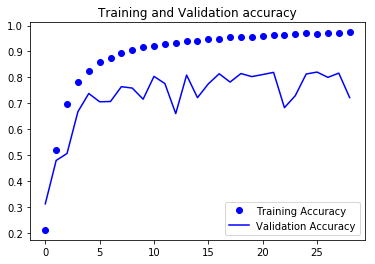

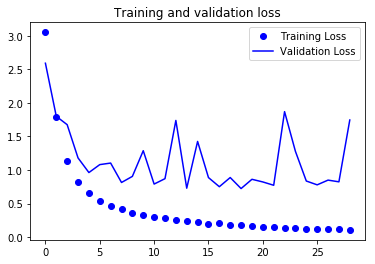

In [21]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

<br>
<br>
<br>
<br>

# 8) AlexNet
### Create Framework

In [19]:
model_alexnet = Sequential()

# 1st Convolutional Layer
model_alexnet.add(Conv2D(32,(3,3),                
                 input_shape=(32, 32, 1),
                 padding='same',
                 activation='relu'))

#pooling
model_alexnet.add(MaxPooling2D(pool_size=(2,2), padding='same')) 
model_alexnet.add(BatchNormalization())

# 2nd Convolutional Layer
model_alexnet.add(Conv2D(64,(3,3),
                padding='same',
                activation='relu'))

#pooling
model_alexnet.add(MaxPooling2D(pool_size=(2,2), padding='same'))
model_alexnet.add(BatchNormalization())

# 3rd Convolutional Layer
model_alexnet.add(Conv2D(64,(3,3),
                padding='same',
                activation='relu'))
model_alexnet.add(BatchNormalization())

#4th Convolutional Layer
model_alexnet.add(Conv2D(128,(3,3),
                padding='same',
                activation='relu'))
model_alexnet.add(BatchNormalization())

#5th Convolutional Layer
model_alexnet.add(Conv2D(128,(3,3),
                padding='same',
                activation='relu'))

#pooling
model_alexnet.add(MaxPooling2D(pool_size=(3,3), padding='same'))
model_alexnet.add(BatchNormalization())


#Flatten
model_alexnet.add(Flatten())

#1st Dense Layer
model_alexnet.add(Dense(128, input_shape=(32,32,1),
               activation='relu', kernel_initializer='glorot_uniform'))
model_alexnet.add(Dropout(0.10))
model_alexnet.add(BatchNormalization())

#2nd Dense Layer
model_alexnet.add(Dense(256,
               activation='relu', kernel_initializer='glorot_uniform'))
model_alexnet.add(Dropout(0.20))
model_alexnet.add(BatchNormalization())

# # 3rd Dense Layer
model_alexnet.add(Dense(512,
               activation='relu', kernel_initializer='glorot_uniform'))
model_alexnet.add(Dropout(0.40))
model_alexnet.add(BatchNormalization())

#output layer
model_alexnet.add(Dense(43, activation='softmax'))

#Compile 
model_alexnet.compile(loss='categorical_crossentropy', optimizer='adam',
 metrics=['accuracy'])

# Set callback functions to early stop training and save the best model so far
callbacks = [EarlyStopping(monitor='val_loss', patience=10),
             ModelCheckpoint(filepath='best_model_alexnet.h5', monitor='val_loss', save_best_only=True)]

#summary of Model
model_alexnet.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 8, 8, 64)          256       
___________________________

In [20]:
#fit model
history = model_alexnet.fit(X_train_Gray, y_train_OneHot,
          epochs=100,
          batch_size=64,
          callbacks=callbacks,
          validation_data = (X_val_Gray, y_val_OneHot))

Instructions for updating:
Use tf.cast instead.
Train on 34799 samples, validate on 4410 samples
Epoch 1/100
34799/34799 [==============================] - 78s 2ms/step - loss: 1.4084 - acc: 0.6194 - val_loss: 0.3864 - val_acc: 0.8841
Epoch 2/100
34799/34799 [==============================] - 76s 2ms/step - loss: 0.1575 - acc: 0.9526 - val_loss: 0.2346 - val_acc: 0.9261
Epoch 3/100
34799/34799 [==============================] - 75s 2ms/step - loss: 0.0839 - acc: 0.9748 - val_loss: 0.2569 - val_acc: 0.9268
Epoch 4/100
34799/34799 [==============================] - 75s 2ms/step - loss: 0.0555 - acc: 0.9835 - val_loss: 0.2238 - val_acc: 0.9424
Epoch 5/100
34799/34799 [==============================] - 76s 2ms/step - loss: 0.0477 - acc: 0.9862 - val_loss: 0.2131 - val_acc: 0.9488
Epoch 6/100
34799/34799 [==============================] - 75s 2ms/step - loss: 0.0458 - acc: 0.9858 - val_loss: 0.2062 - val_acc: 0.9517
Epoch 7/100
34799/34799 [==============================] - 75s 2ms/step - l

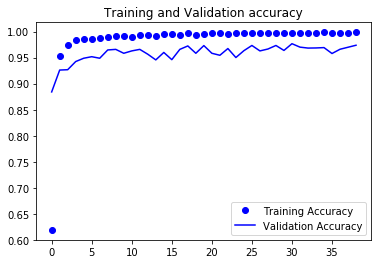

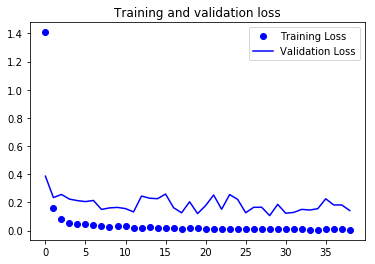

In [21]:
accuracy = history.history['acc']
val_accuracy = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [23]:
score = model_alexnet.evaluate(X_test_Gray, y_test_OneHot,verbose=0)
print('Test Accuracy : {:.4f}'.format(score[1]))

Test Accuracy : 0.9629


#### ^ Over 5% performance Increase
<br>
<br>

In [102]:
#turn prediction value array into onehot encoded array
ohe_array = y_predict
ohe_array = (ohe_array == ohe_array.max(axis=1, keepdims=1)).astype(float)

#print out classification report
print(classification_report(ohe_array, y_test_OneHot))

              precision    recall  f1-score   support

           0       1.00      0.97      0.98        62
           1       0.99      0.96      0.98       743
           2       0.99      0.99      0.99       755
           3       0.97      0.94      0.95       467
           4       0.98      0.99      0.98       649
           5       0.99      0.95      0.97       657
           6       0.88      1.00      0.94       132
           7       0.95      0.98      0.97       435
           8       0.95      0.98      0.97       436
           9       1.00      0.98      0.99       489
          10       0.99      0.99      0.99       656
          11       0.93      0.94      0.94       416
          12       1.00      0.92      0.96       748
          13       0.99      1.00      1.00       717
          14       1.00      0.98      0.99       276
          15       0.99      1.00      1.00       208
          16       1.00      1.00      1.00       150
          17       0.98    

# 9) Results & Future Things To Do

### Results

-  Simple Convolutioinal NN overfit. Training accuracy >95% while validation data <80%
-  AlexNet archetecture did not overfit much. Training accuracy & validation accuracy >95%   

### Things to do
-  Balance classes or assign different class weights
-  Increase class #21 and #27 accuracy